In [1]:
import pandas as pd
import numpy as np
import mplfinance as mpf
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [45,30]
plt.rc('font', size = 20)
import warnings
warnings.filterwarnings('ignore')

In [2]:
appl = pd.read_csv("/Users/kundaimariga/Downloads/AAPL.csv")

In [3]:
appl = appl.astype({'Date': 'datetime64[ns]'})

In [4]:
rappl =(appl['Close'].diff())
rappl = rappl.replace(np.nan, 0)

In [5]:
appl['return'] = rappl

In [6]:
appl

,Date,Open,High,Low,Close,Adj Close,Volume,return
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.562591,493729600,0.000000
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.573935,601904800,0.013215
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.469369,552160000,-0.121786
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.457407,477131200,-0.013929
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.500339,447610800,0.050000
...,...,...,...,...,...,...,...,...
2763,2020-12-23,132.160004,132.429993,130.779999,130.960007,130.347565,88223700,-0.919998
2764,2020-12-24,131.320007,133.460007,131.100006,131.970001,131.352829,54930100,1.009994
2765,2020-12-28,133.990005,137.339996,133.509995,136.690002,136.050766,124486200,4.720001
2766,2020-12-29,138.050003,138.789993,134.339996,134.869995,134.239273,121047300,-1.820007


# Check for autocorrlation and stationarity in adj close

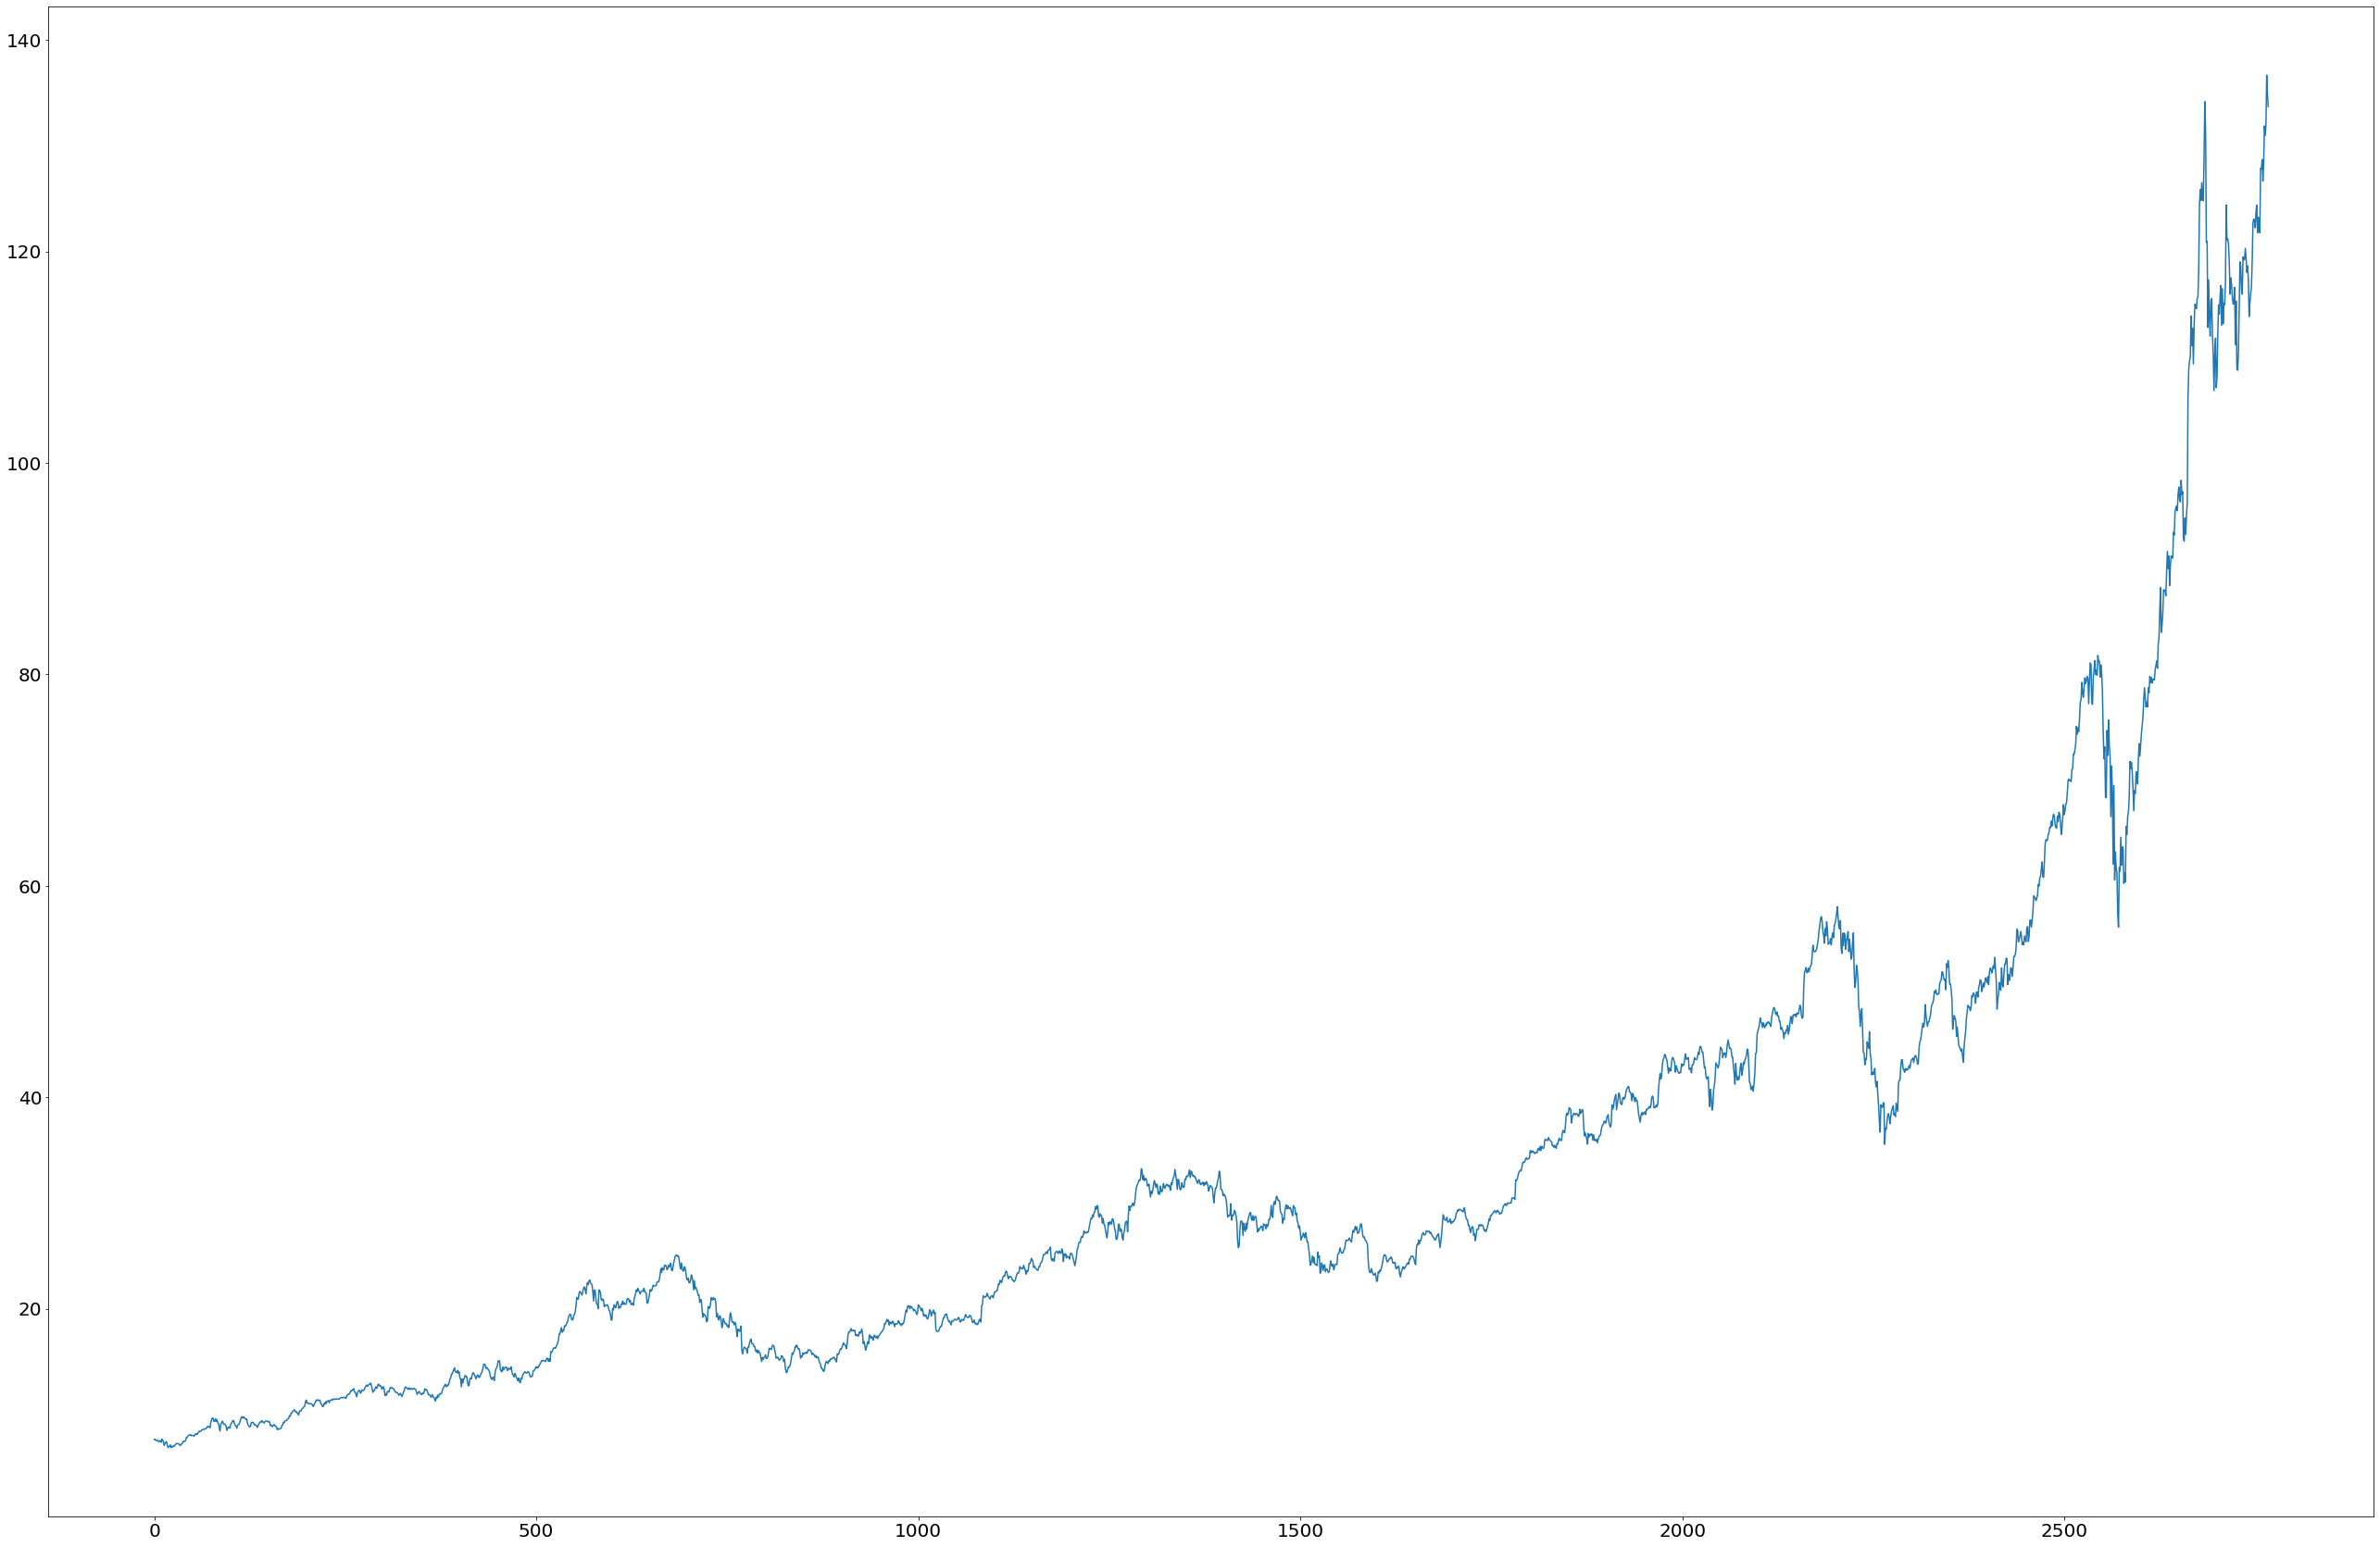

In [7]:
plt.plot(appl['Close'])

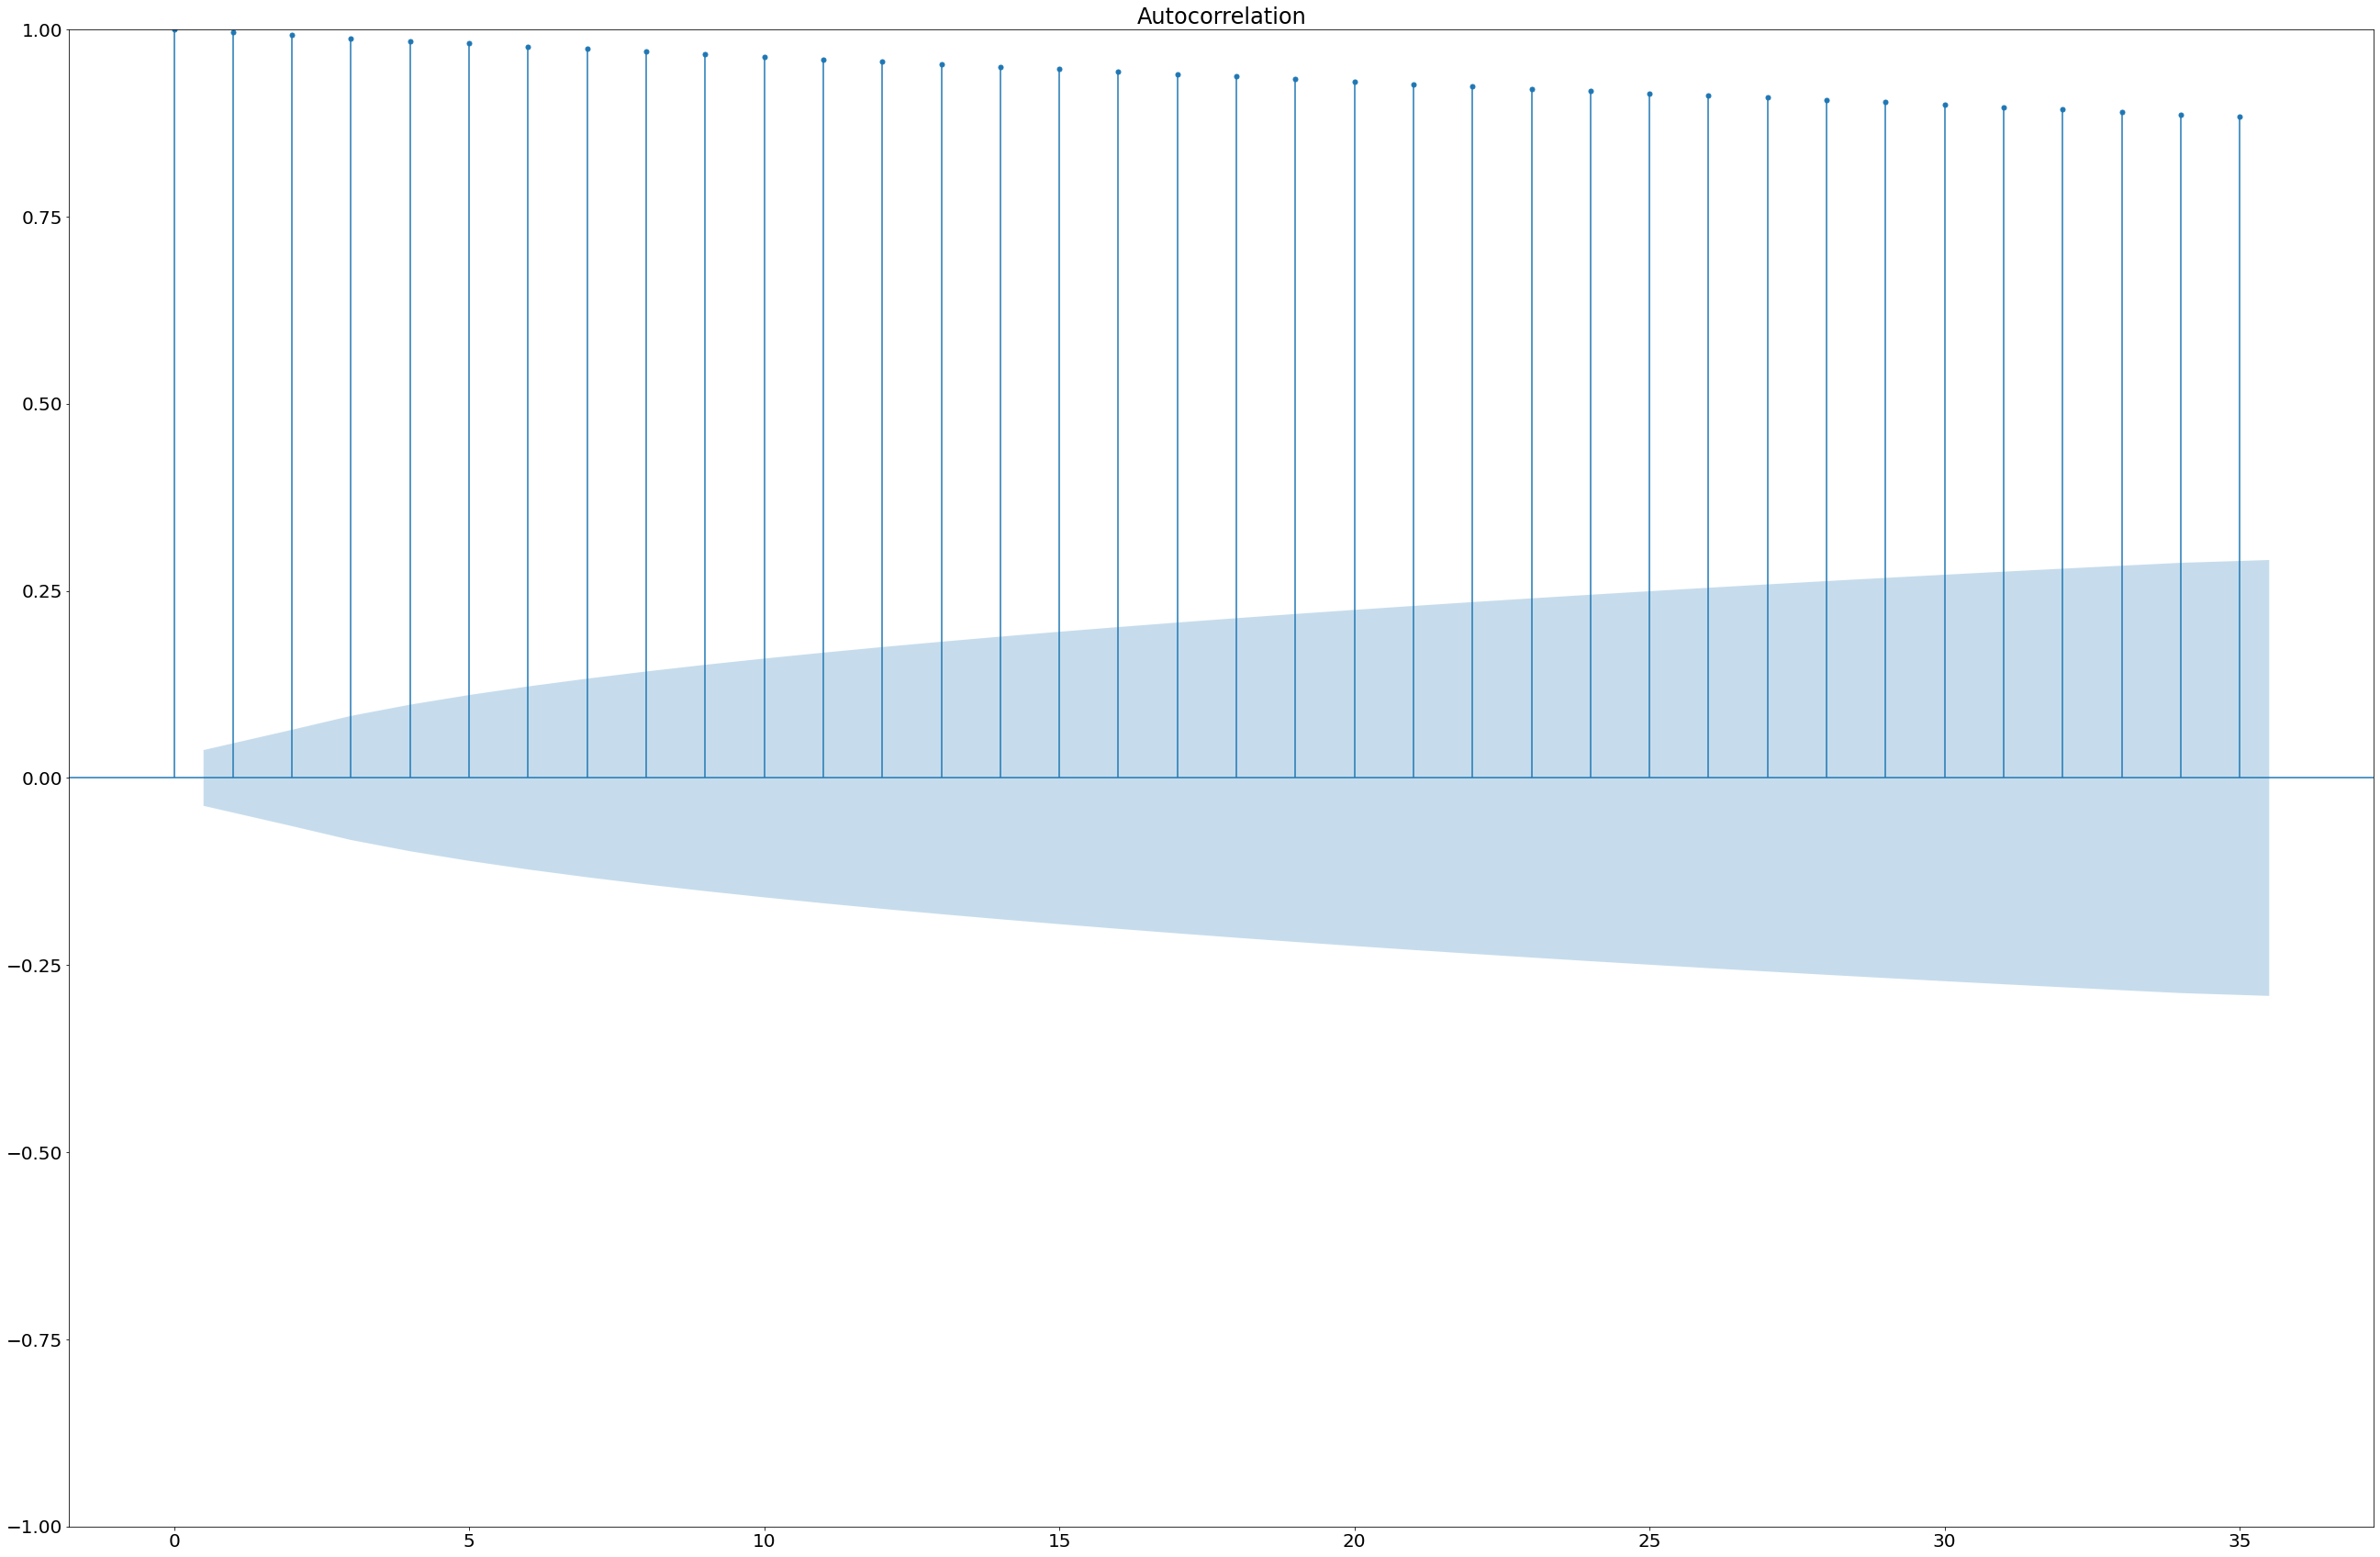

In [8]:
plot_acf(appl['Close']);

In [9]:
#there is some serial correlation between returns.

In [10]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(appl['Close'], autolag = 'AIC')
print("1. ADF: ", dftest[0])
print("2. P-value: ", dftest[1])
print("3. Num of Lags: ", dftest[2])
print("4. Num of Observations used for ADF Regression and Critical Values Calculations: ", dftest[3])
print("5. Critical Values: ")
for key, val in dftest[4].items():
    print("\t", key, val)

1. ADF:  3.382581999909388
2. P-value:  1.0
3. Num of Lags:  28
4. Num of Observations used for ADF Regression and Critical Values Calculations:  2739
5. Critical Values: 
	 1% -3.4327397185476918
	 5% -2.8625958054606793
	 10% -2.5673320392686283


In [11]:
#the data is non-stationary

In [12]:
#load tweet polarity data
appltweets = pd.read_csv("/Users/kundaimariga/Downloads/AAPL-5.csv")

In [13]:
appltweets

,date,ts_polarity,twitter_volume
0,2016-01-01,0.119693,417
1,2016-01-02,0.140774,495
2,2016-01-03,0.181132,518
3,2016-01-04,0.070389,1133
4,2016-01-05,0.133635,1430
...,...,...,...
1336,2019-08-29,0.056460,1083
1337,2019-08-30,0.106096,1005
1338,2019-08-31,0.151625,224
1339,2019-09-01,0.059887,200


In [14]:
#need to rename data column so that I can merge it with the stock data
appltweets = appltweets.rename(columns={'date': 'Date'})

In [15]:
appltweets = appltweets.astype({'Date': 'datetime64[ns]'})

In [16]:
#merge tweet data
applfull = pd.merge(appl, appltweets, on = 'Date')
applfull = applfull.astype({'Date': 'datetime64[ns]'})
applnew = applfull.set_index('Date')
applnew

,Open,High,Low,Close,Adj Close,Volume,return,ts_polarity,twitter_volume
Date,,,,,,,,,
2016-01-04,25.652500,26.342501,25.500000,26.337500,24.286833,270597600,0.022499,0.070389,1133
2016-01-05,26.437500,26.462500,25.602501,25.677500,23.678219,223164000,-0.660000,0.133635,1430
2016-01-06,25.139999,25.592501,24.967501,25.174999,23.214844,273829600,-0.502501,0.072042,1949
2016-01-07,24.670000,25.032499,24.107500,24.112499,22.235069,324377600,-1.062500,0.074369,2289
2016-01-08,24.637501,24.777500,24.190001,24.240000,22.352642,283192000,0.127501,0.051595,2235
...,...,...,...,...,...,...,...,...,...
2019-08-26,51.465000,51.797501,51.264999,51.622501,50.788677,104174400,0.962501,0.072340,888
2019-08-27,51.965000,52.137501,50.882500,51.040001,50.215584,103493200,-0.582500,0.117541,962
2019-08-28,51.025002,51.430000,50.830002,51.382500,50.552551,63755200,0.342499,0.061477,895


In [17]:
applnew.index

DatetimeIndex(['2016-01-04', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-11', '2016-01-12', '2016-01-13',
               '2016-01-14', '2016-01-15',
               ...
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-26', '2019-08-27', '2019-08-28',
               '2019-08-29', '2019-08-30'],
              dtype='datetime64[ns]', name='Date', length=922, freq=None)

In [18]:
#index the data by date
applnew['Date'] = pd.to_datetime(applnew.index)
applnew['Date'] = applnew['Date'].apply(mpl_dates.date2num)

applnew = applnew.loc[:,['Date', 'Adj Close','return','Volume', 'ts_polarity', 'twitter_volume']]
appl = applnew

In [19]:
appl = appl.replace(np.nan, 0)

In [20]:
appl

,Date,Adj Close,return,Volume,ts_polarity,twitter_volume
Date,,,,,,
2016-01-04,16804.0,24.286833,0.022499,270597600,0.070389,1133
2016-01-05,16805.0,23.678219,-0.660000,223164000,0.133635,1430
2016-01-06,16806.0,23.214844,-0.502501,273829600,0.072042,1949
2016-01-07,16807.0,22.235069,-1.062500,324377600,0.074369,2289
2016-01-08,16808.0,22.352642,0.127501,283192000,0.051595,2235
...,...,...,...,...,...,...
2019-08-26,18134.0,50.788677,0.962501,104174400,0.072340,888
2019-08-27,18135.0,50.215584,-0.582500,103493200,0.117541,962
2019-08-28,18136.0,50.552551,0.342499,63755200,0.061477,895


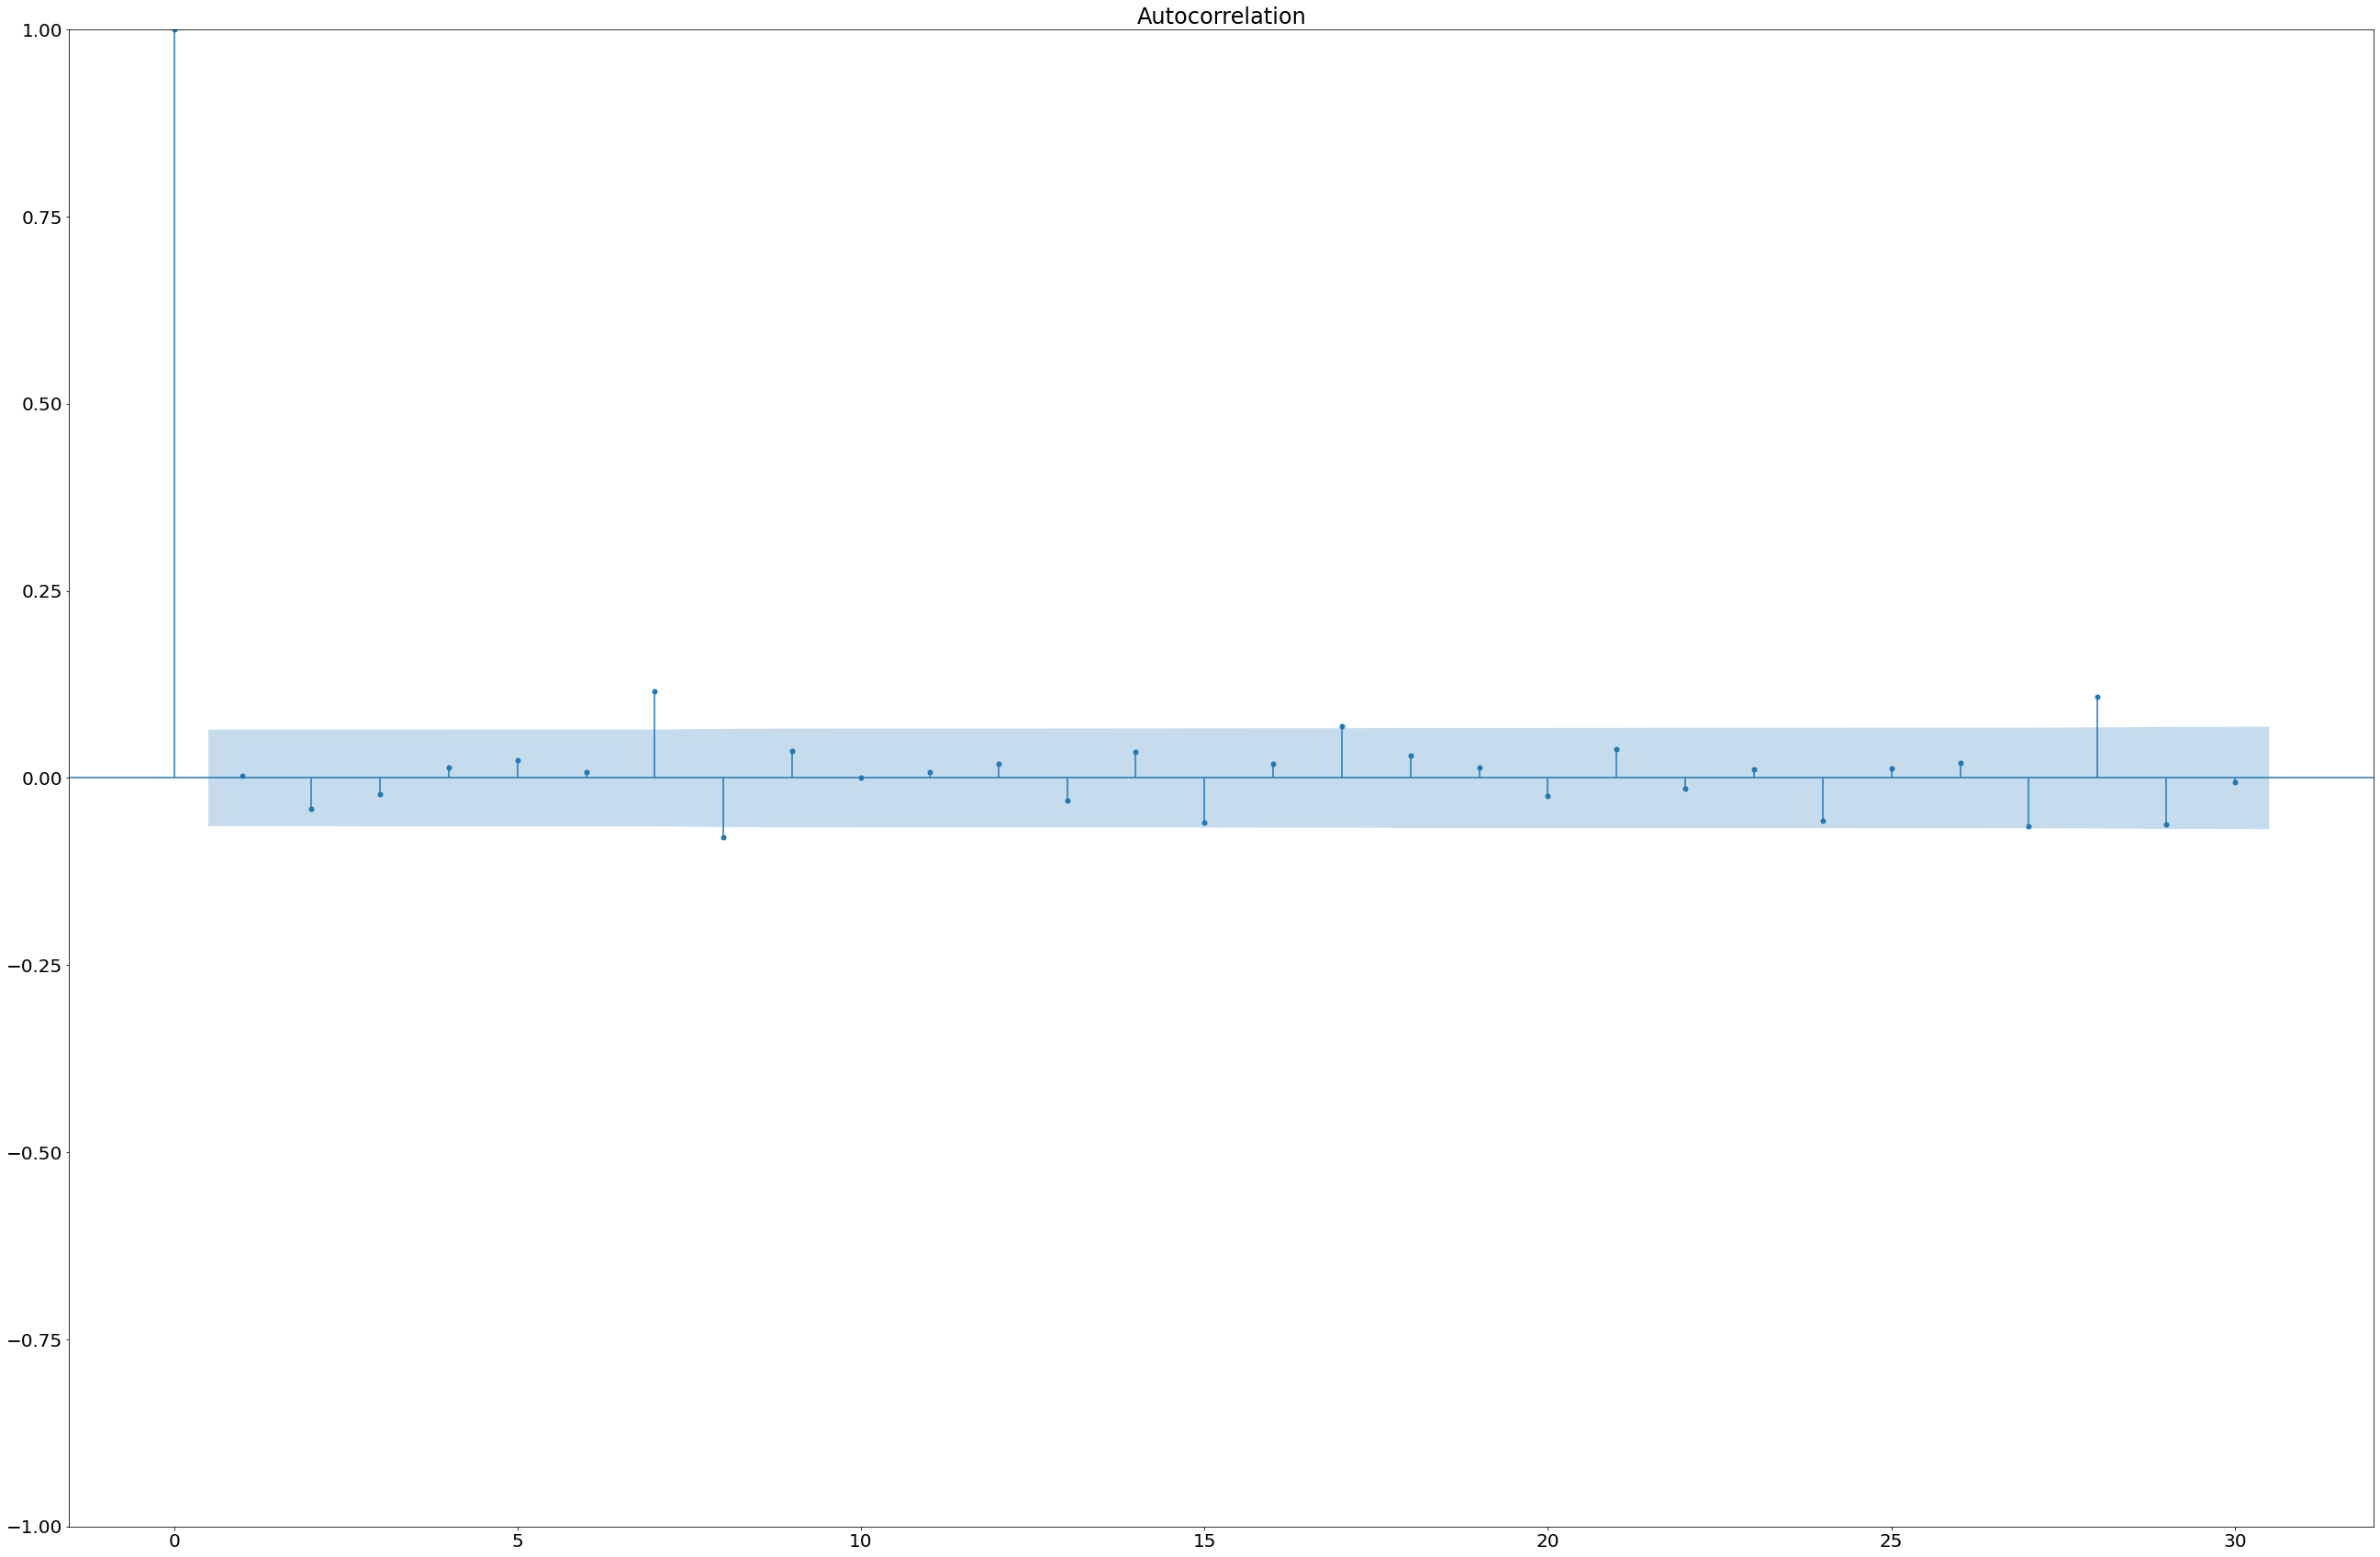

In [21]:
plot_acf(appl['return']);

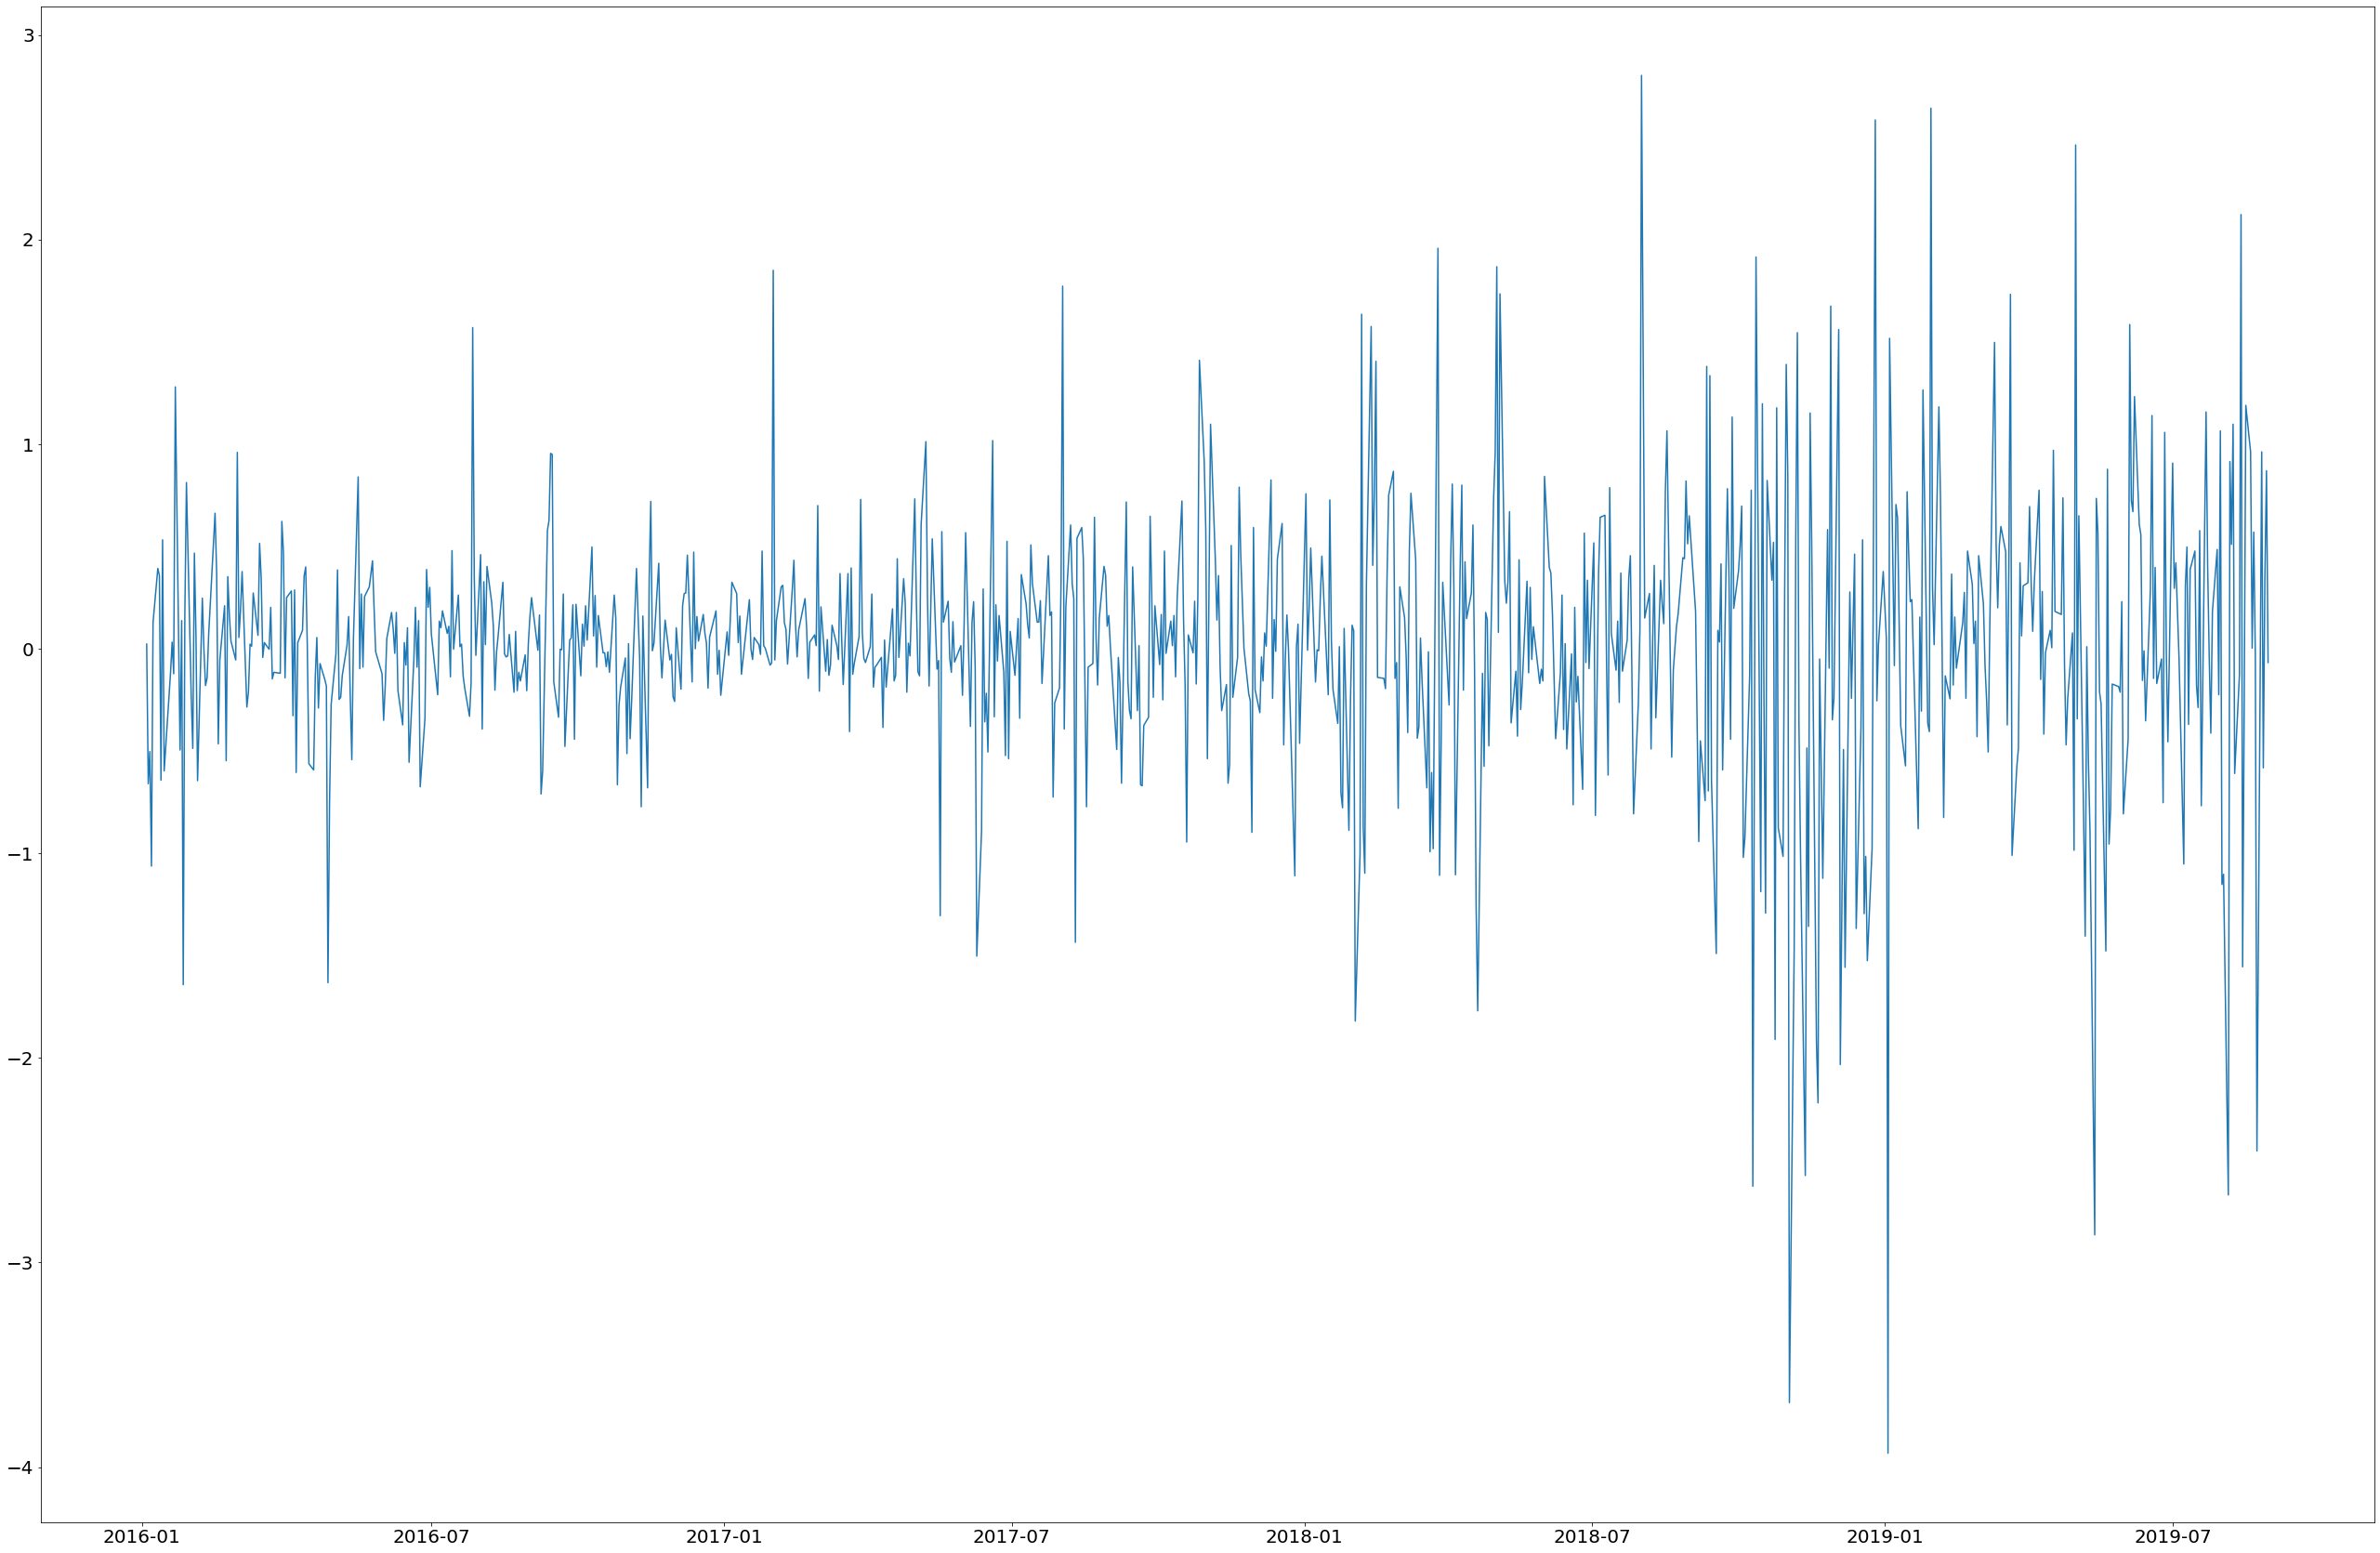

In [22]:
plt.plot(appl['return'])

# Check for ideal model

In [23]:
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [24]:
ideal_fit = auto_arima(appl['return'], trace=True, supress_warnings=True)
ideal_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.20 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1799.104, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1801.095, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1801.094, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1798.872, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1802.872, Time=0.23 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 3.396 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  922
Model:                        SARIMAX   Log Likelihood                -898.436
Date:                Fri, 10 Dec 2021   AIC                           1798.872
Time:                        17:23:22   BIC                           1803.699
Sample:                             0   HQIC                          1800.714
                                - 922                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.4111      0.010     41.411      0.000       0.392       0.431
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              1238.99
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               6.03   Skew:                            -0.58
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
#the model described above assumes that a model with just white noise is ideal. Looking at the plots for my data
#I dont believe this to be true due to the volatility shown 

In [26]:
appl['AdjClose'] = appl['Adj Close']

# MODEL 1 - ARIMAX model order (0,1,0)

In [27]:
print(appl.shape)
train = appl.iloc[:-30]
test = appl.iloc[-30:]
print(train.shape, test.shape)

(922, 7)
(892, 7) (30, 7)


In [28]:
train.dtypes

Date              float64
Adj Close         float64
return            float64
Volume              int64
ts_polarity       float64
twitter_volume      int64
AdjClose          float64
dtype: object

In [29]:
train

,Date,Adj Close,return,Volume,ts_polarity,twitter_volume,AdjClose
Date,,,,,,,
2016-01-04,16804.0,24.286833,0.022499,270597600,0.070389,1133,24.286833
2016-01-05,16805.0,23.678219,-0.660000,223164000,0.133635,1430,23.678219
2016-01-06,16806.0,23.214844,-0.502501,273829600,0.072042,1949,23.214844
2016-01-07,16807.0,22.235069,-1.062500,324377600,0.074369,2289,22.235069
2016-01-08,16808.0,22.352642,0.127501,283192000,0.051595,2235,22.352642
...,...,...,...,...,...,...,...
2019-07-15,18092.0,50.282806,0.477501,67789600,0.161794,490,50.282806
2019-07-16,18093.0,50.108826,-0.177502,67467200,0.142708,676,50.108826
2019-07-17,18094.0,49.827045,-0.287498,56430000,0.128261,633,49.827045


In [30]:
dif=test['Adj Close'].diff()
dif = dif.replace(np.nan, 0)

In [31]:
import pyflux as pf
model = pf.ARIMAX(appl, formula='AdjClose~ts_polarity', ma=0, ar=0, integ=1,
              family=pf.Normal())
x = model.fit("MLE")
x.summary()

Normal ARIMAX(0,1,0)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced AdjClose                Method: MLE                                       
Start Date: 2016-01-04 00:00:00                         Log Likelihood: -861.698                          
End Date: 2019-08-30 00:00:00                           AIC: 1729.396                                     
Number of observations: 921                             BIC: 1743.8724                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
Beta 1                                   -0.0403    0.0472     -0.8547  0.3927   (-0.1327 | 0.0521)       
Beta ts_polarity                     

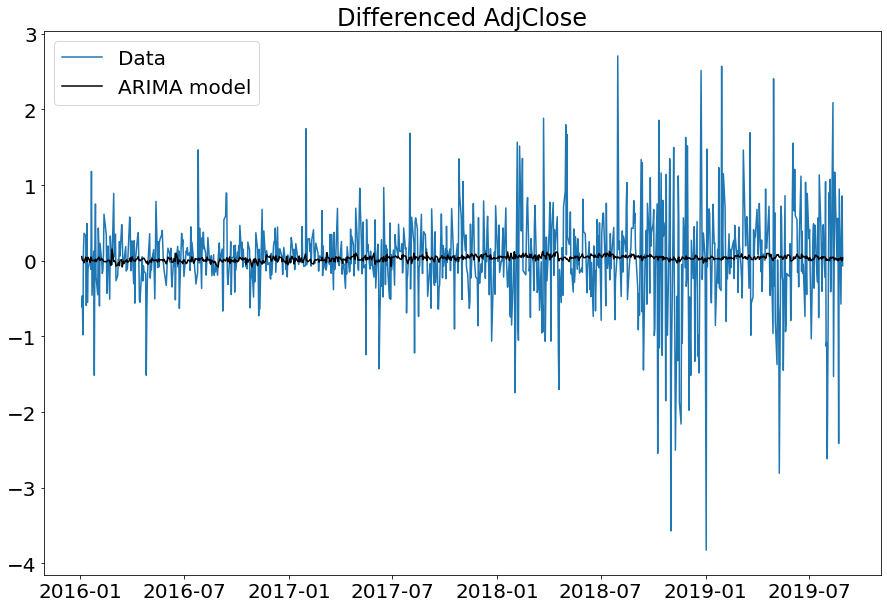

In [32]:
model.plot_fit(figsize=(15,10))

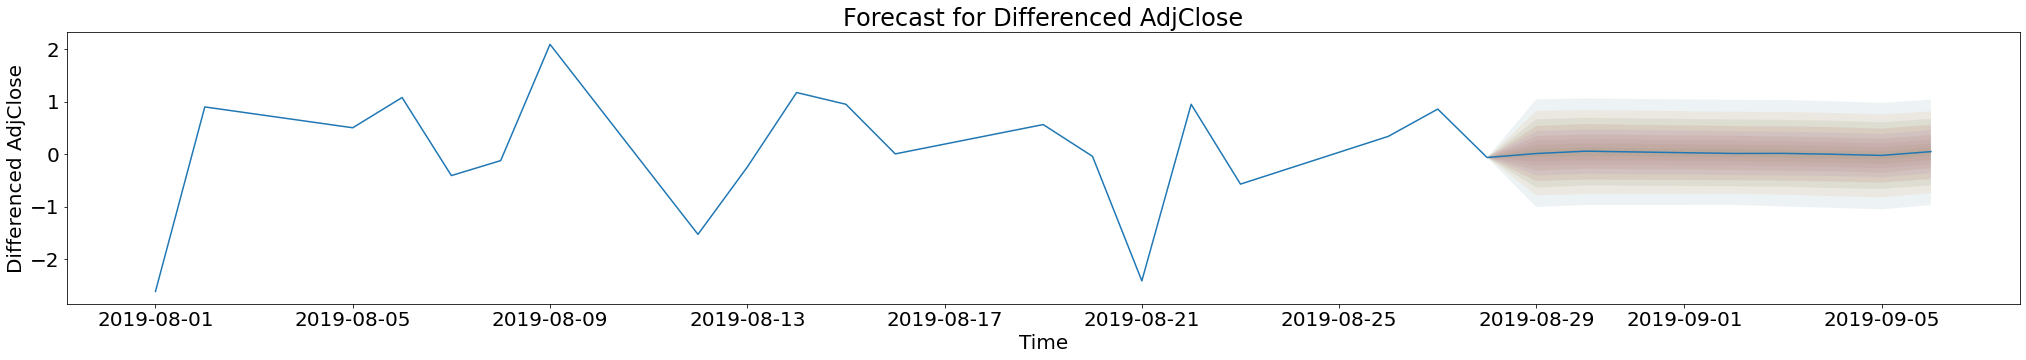

In [33]:
model.plot_predict(h=7, oos_data=appl, figsize=(35,5))

In [34]:
model_est=model.predict(h=7, oos_data=appl,)
model_est

,Differenced AdjClose
Date,
2019-08-29,0.009429
2019-08-30,0.054118
2019-09-02,0.010597
2019-09-03,0.012241
2019-09-04,-0.003851
2019-09-05,-0.026570
2019-09-06,0.045448


In [35]:
model_est.values

array([[ 0.0094286 ],
       [ 0.05411849],
       [ 0.01059673],
       [ 0.01224138],
       [-0.00385132],
       [-0.02656971],
       [ 0.04544759]])

In [36]:
model_est = np.delete(model_est.values, [2])
model_est

array([ 0.0094286 ,  0.05411849,  0.01224138, -0.00385132, -0.02656971,
        0.04544759])

In [37]:
futureobs = pd.read_csv("/Users/kundaimariga/Downloads/AAPL-13.csv")

In [38]:
futureobs = futureobs.set_index('Date')

In [39]:
futureobs['AdjClose'] = futureobs['Adj Close']
dif=futureobs['AdjClose'].diff()
dif = dif.replace(np.nan, 0)

In [40]:
dif = pd.DataFrame(dif)

In [41]:
dif

,AdjClose
Date,
2019-08-29,0.000000
2019-08-30,-0.066303
2019-09-03,-0.746639
2019-09-04,0.857155
2019-09-05,1.004524
2019-09-06,-0.004917


In [42]:
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import mse, rmse
print('Mean Squared Error:', (mean_squared_error(dif, model_est)))

Mean Squared Error: 0.3995853973664994


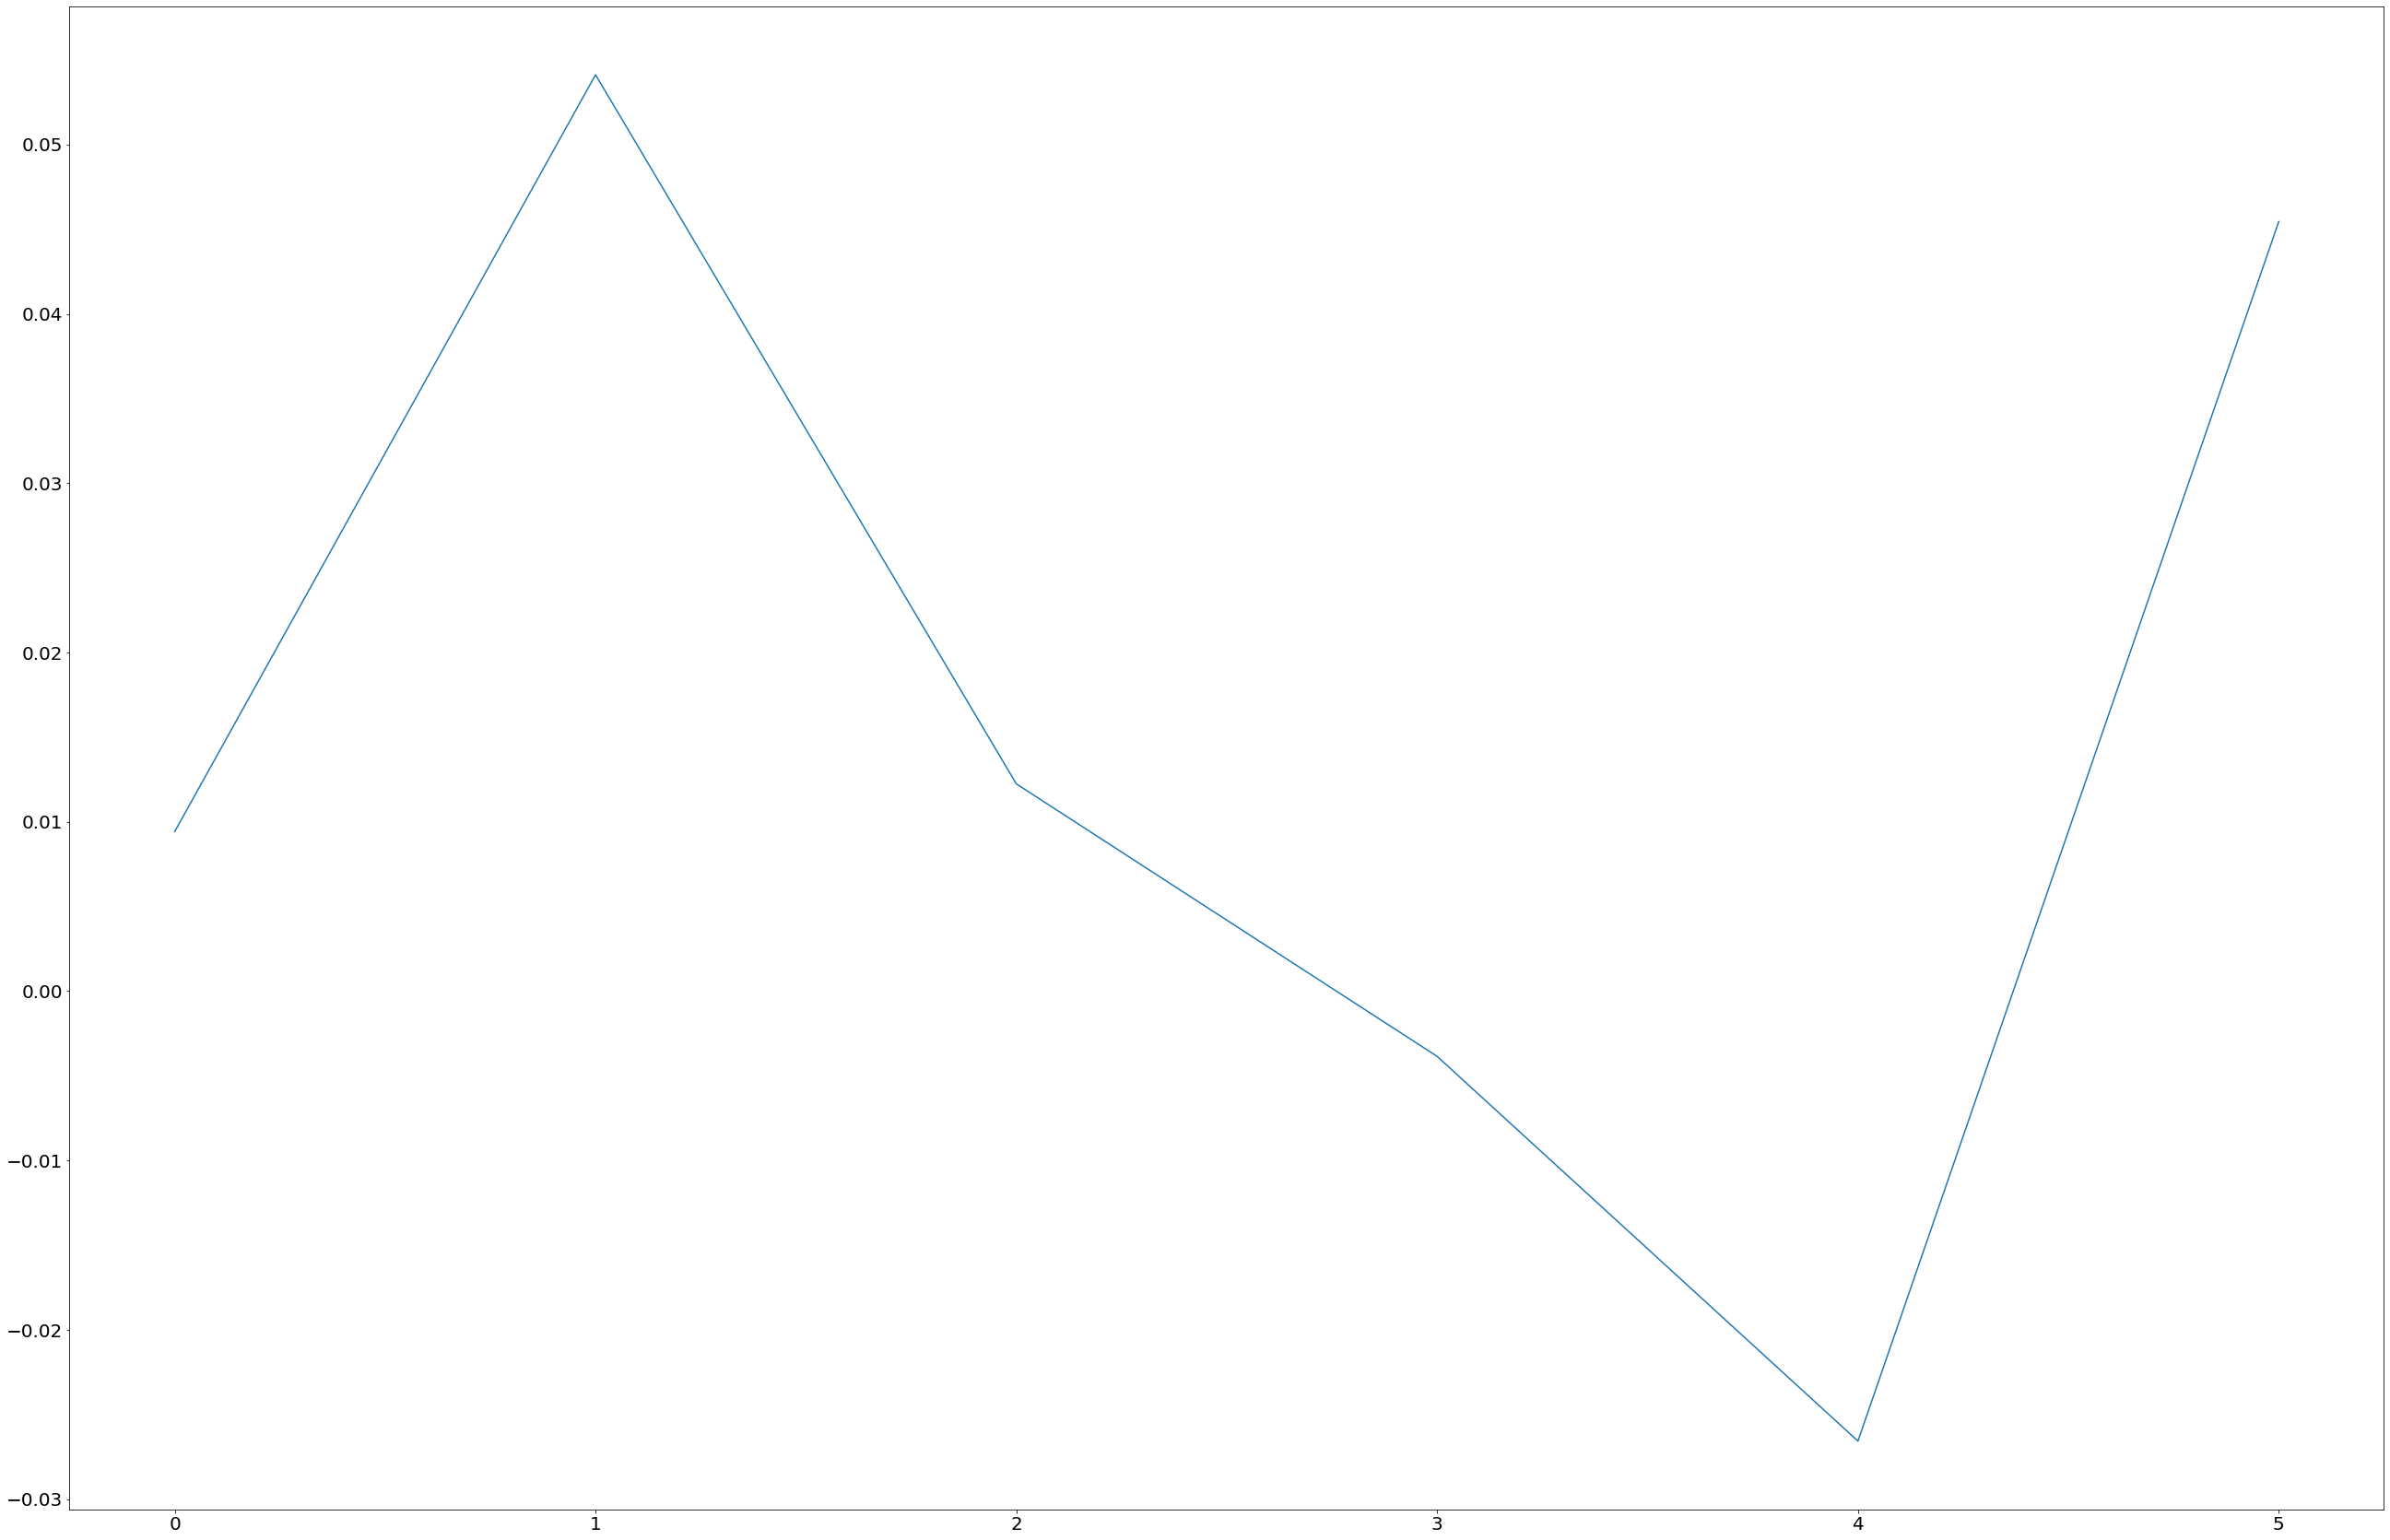

In [43]:
plt.plot(model_est, label = 'forecast')

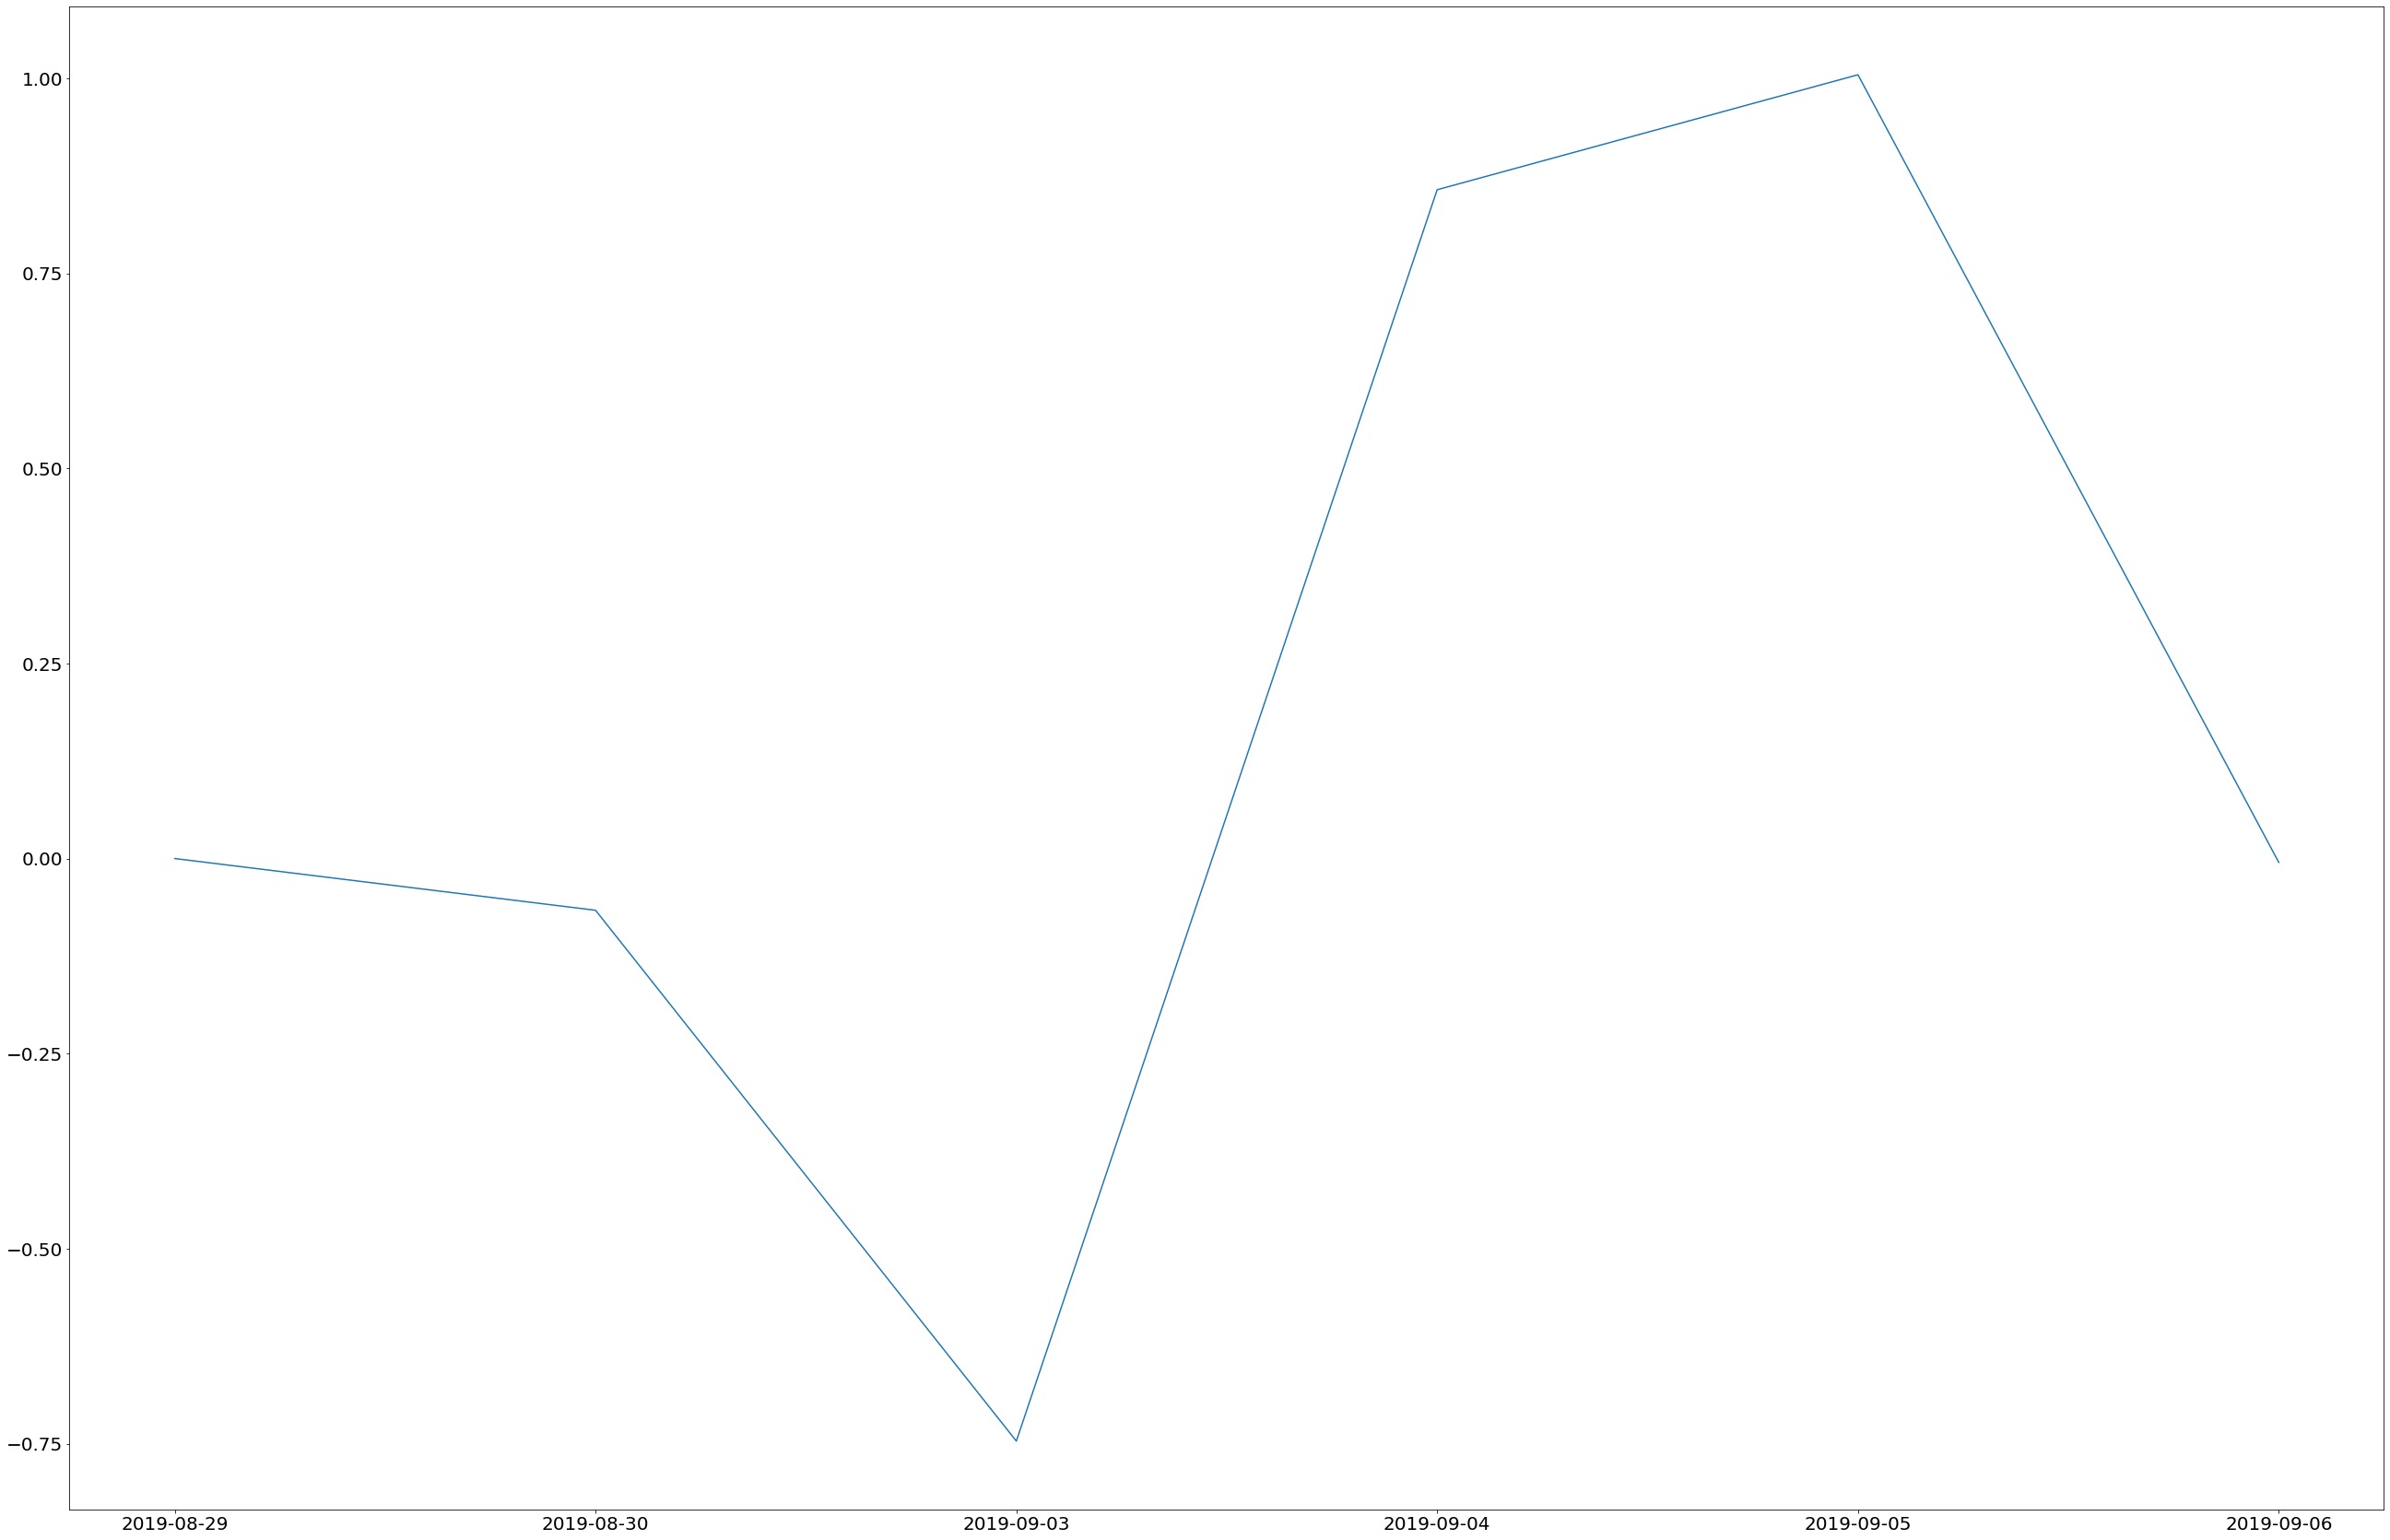

In [44]:
plt.plot(dif, label='actual')

# MODEL 2 - ARIMAX model order (1,1,1)

In [45]:
model2 = pf.ARIMAX(appl, formula='AdjClose~ts_polarity', ma=1, ar=1, integ=1,
              family=pf.Normal())
x2 = model2.fit("MLE")
x2.summary()

Normal ARIMAX(1,1,1)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced AdjClose                Method: MLE                                       
Start Date: 2016-01-05 00:00:00                         Log Likelihood: -860.6844                         
End Date: 2019-08-30 00:00:00                           AIC: 1731.3687                                    
Number of observations: 920                             BIC: 1755.4906                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.0669     0.8993     0.0744   0.9407   (-1.6957 | 1.8295)       
MA(1)                                

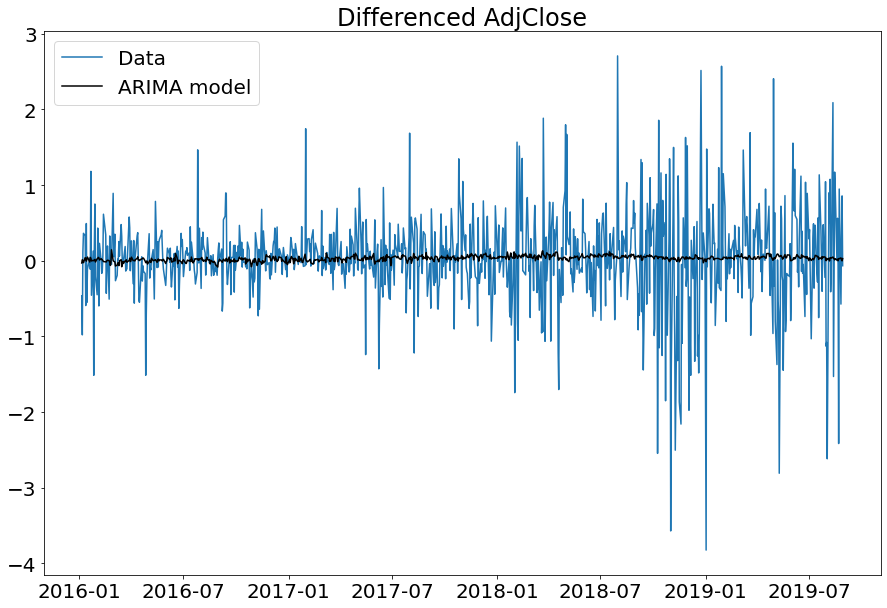

In [46]:
model2.plot_fit(figsize=(15,10))

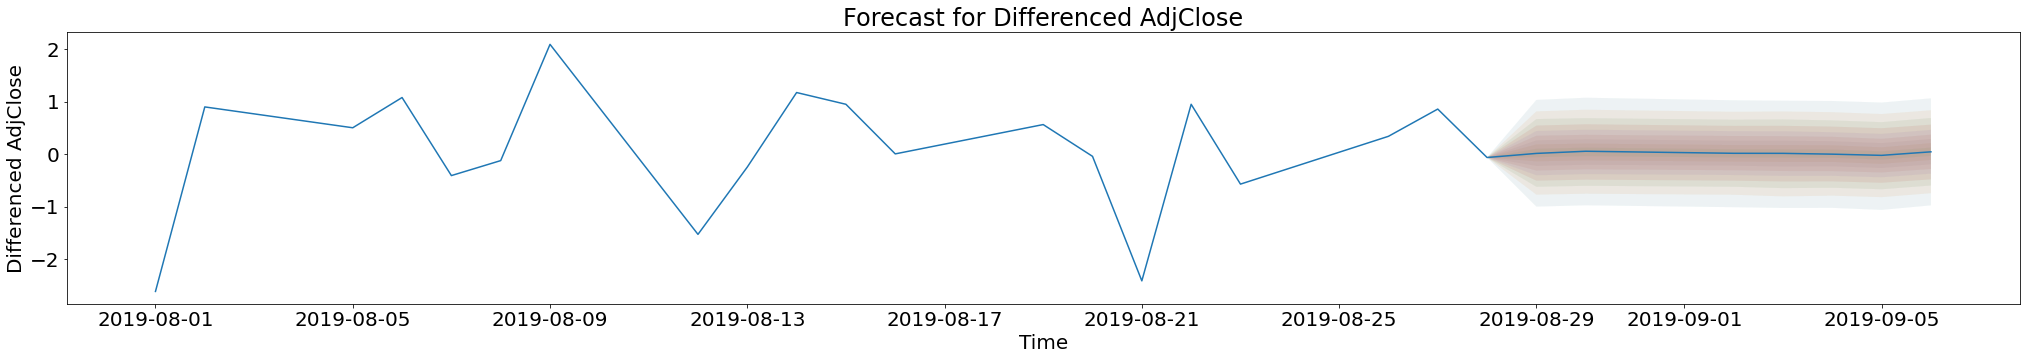

In [47]:
model2.plot_predict(h=7, oos_data=appl, figsize=(35,5))

In [48]:
model2_est=model2.predict(h=7, oos_data=appl,)
model2_est 

,Differenced AdjClose
Date,
2019-08-29,0.011558
2019-08-30,0.052568
2019-09-02,0.013751
2019-09-03,0.012723
2019-09-04,-0.002714
2019-09-05,-0.025442
2019-09-06,0.041811


In [49]:
model2_est.values

array([[ 0.01155798],
       [ 0.05256844],
       [ 0.01375108],
       [ 0.01272342],
       [-0.00271358],
       [-0.02544248],
       [ 0.04181126]])

In [50]:
model2_est = np.delete(model2_est.values, [2])

In [51]:
model2_est

array([ 0.01155798,  0.05256844,  0.01272342, -0.00271358, -0.02544248,
        0.04181126])

In [52]:
print('Mean Squared Error:', (mean_squared_error(dif, model2_est)))

Mean Squared Error: 0.398880624162487


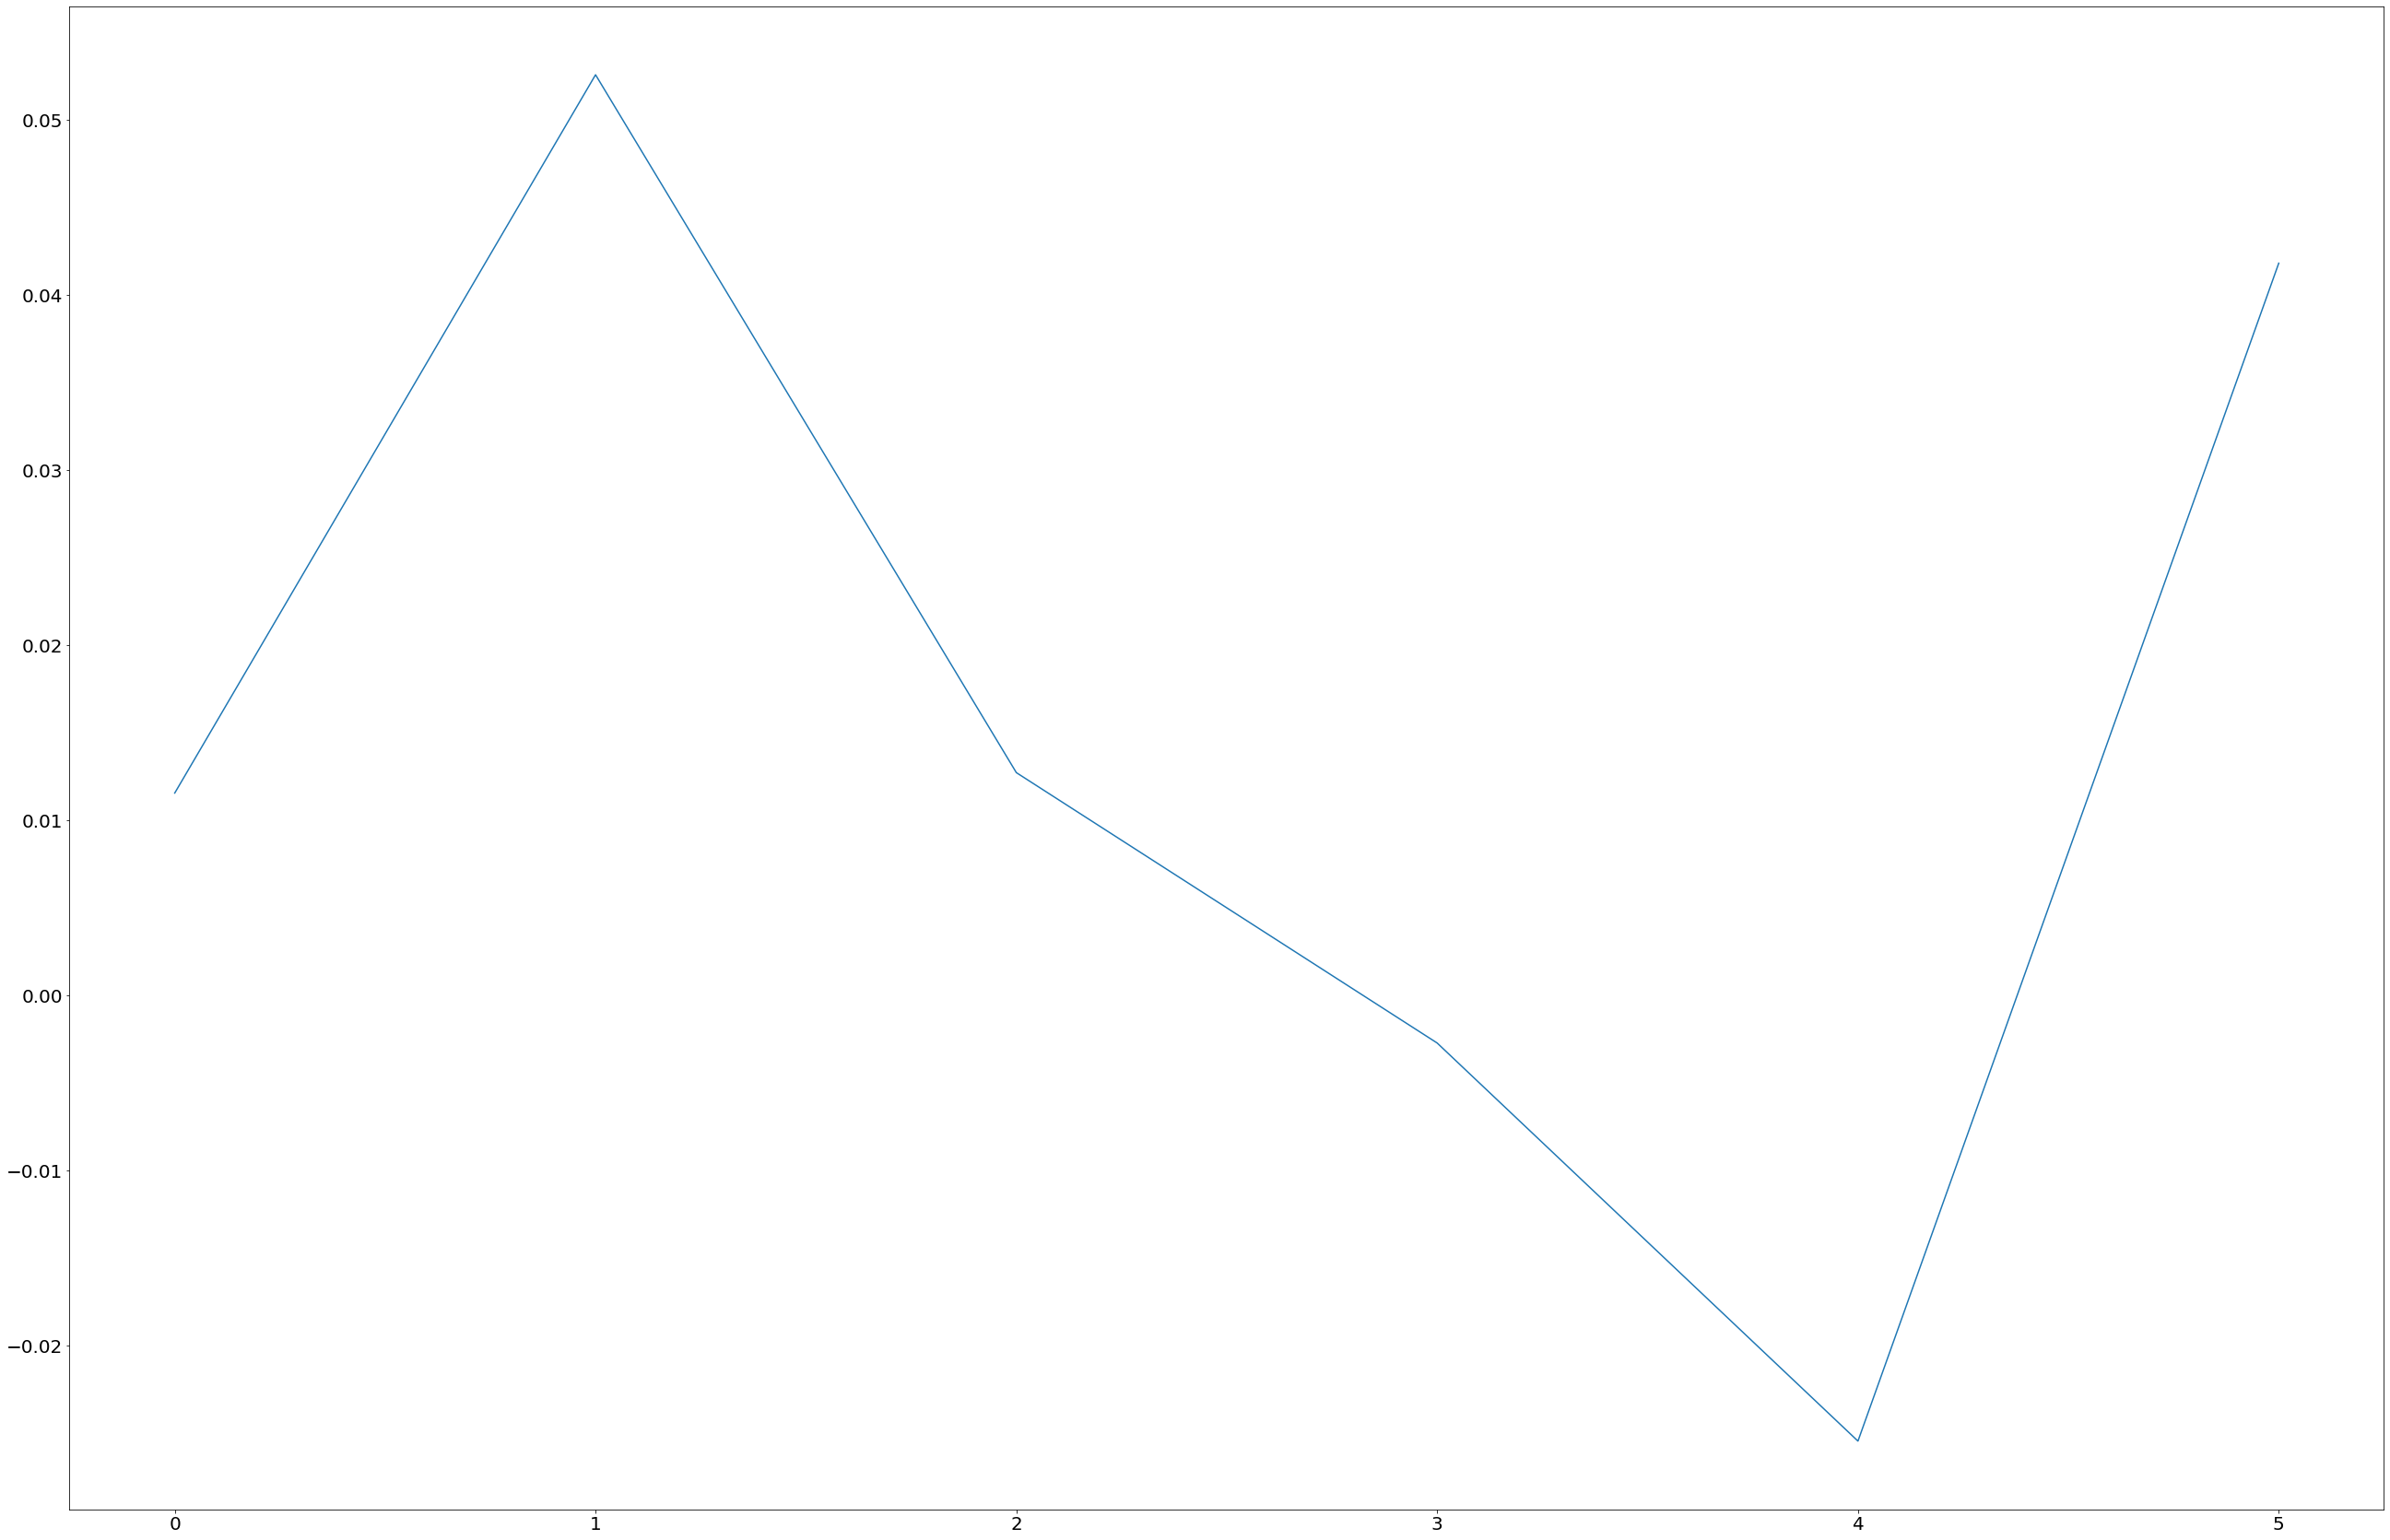

In [53]:
plt.plot(model2_est, label = 'forecast')

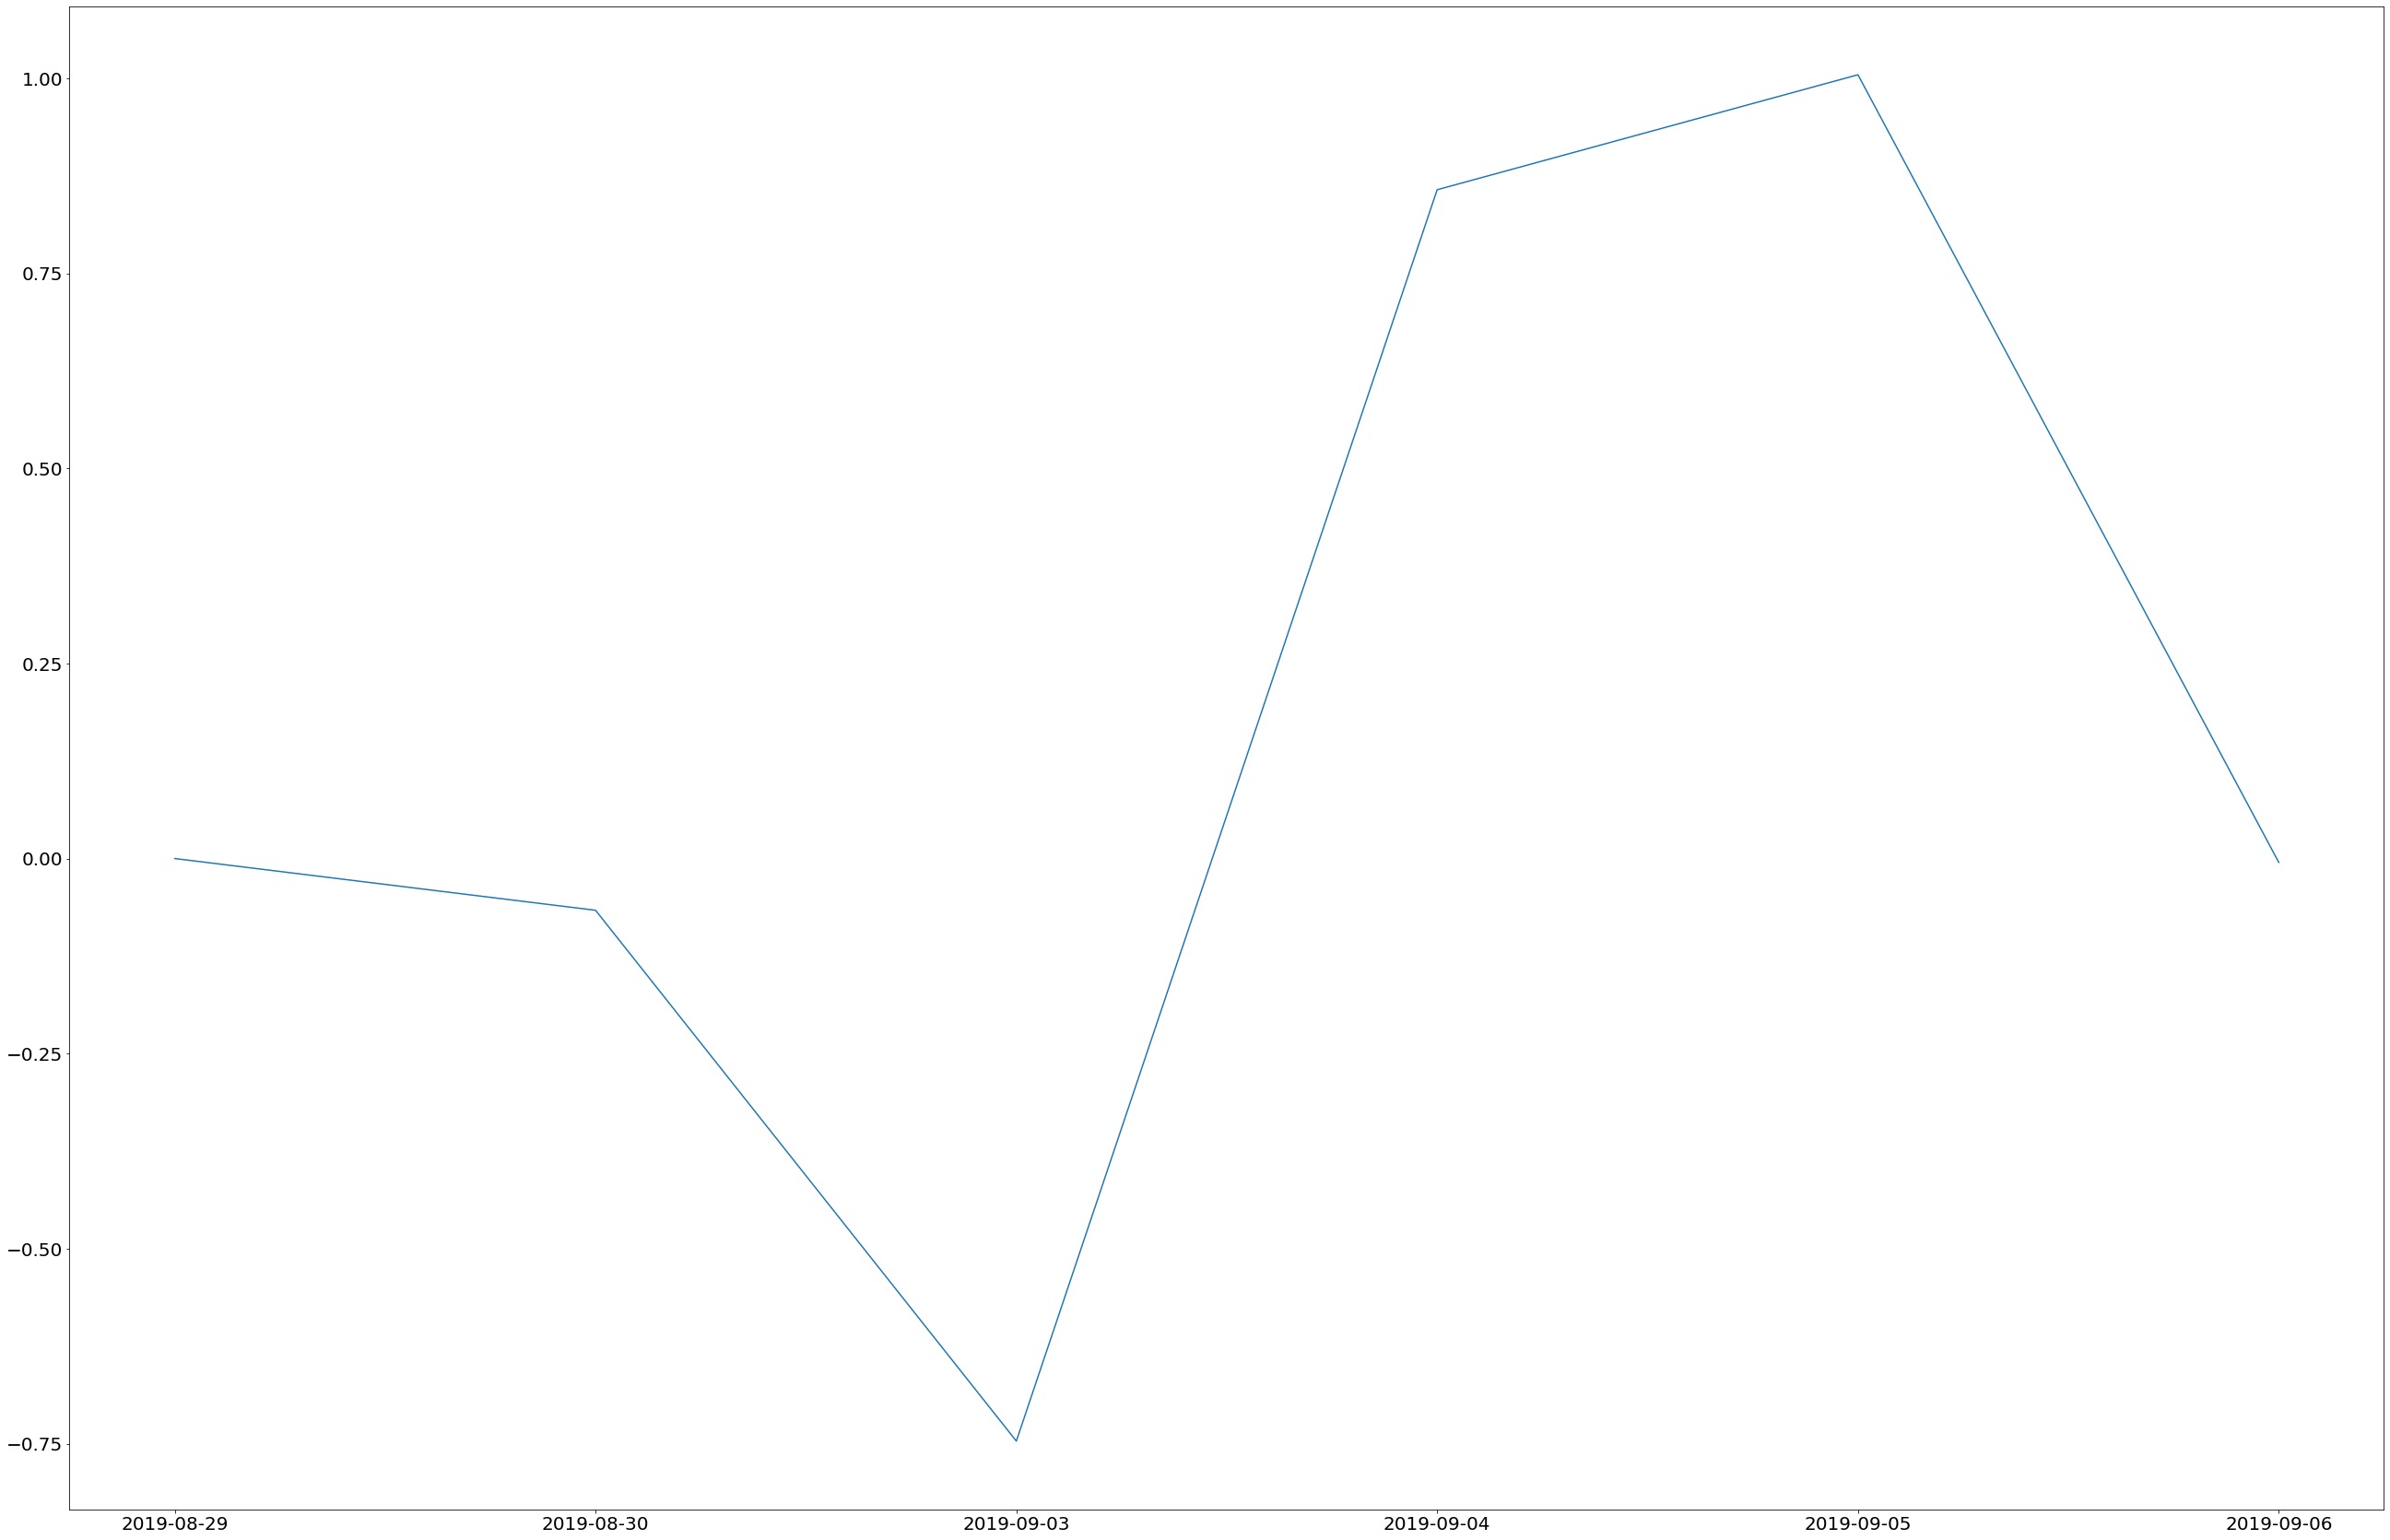

In [54]:
plt.plot(dif, label='actual')

# MODEL 3 - ARIMAX model order (2,1,2)

In [55]:
model3 = pf.ARIMAX(appl, formula='AdjClose~ts_polarity', ma=2, ar=2, integ=1,
              family=pf.Normal())
x3 = model3.fit("MLE")
x3.summary()

Normal ARIMAX(2,1,2)                                                                                      
======================================================= ==================================================
Dependent Variable: Differenced AdjClose                Method: MLE                                       
Start Date: 2016-01-06 00:00:00                         Log Likelihood: -859.0581                         
End Date: 2019-08-30 00:00:00                           AIC: 1732.1163                                    
Number of observations: 919                             BIC: 1765.8793                                    
Latent Variable                          Estimate   Std Error  z        P>|z|    95% C.I.                 
======================================== ========== ========== ======== ======== =========================
AR(1)                                    0.1455     0.4428     0.3285   0.7425   (-0.7225 | 1.0135)       
AR(2)                                

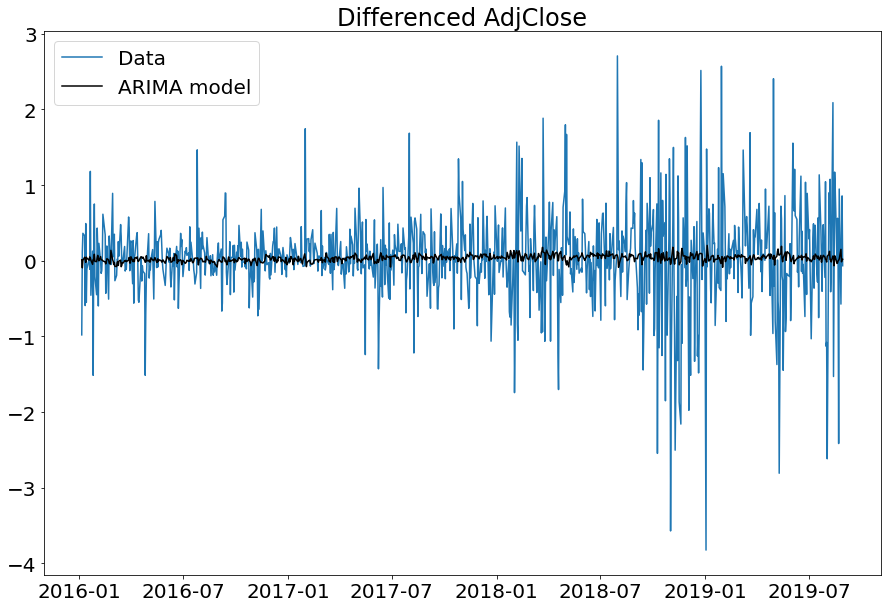

In [56]:
model3.plot_fit(figsize=(15,10))

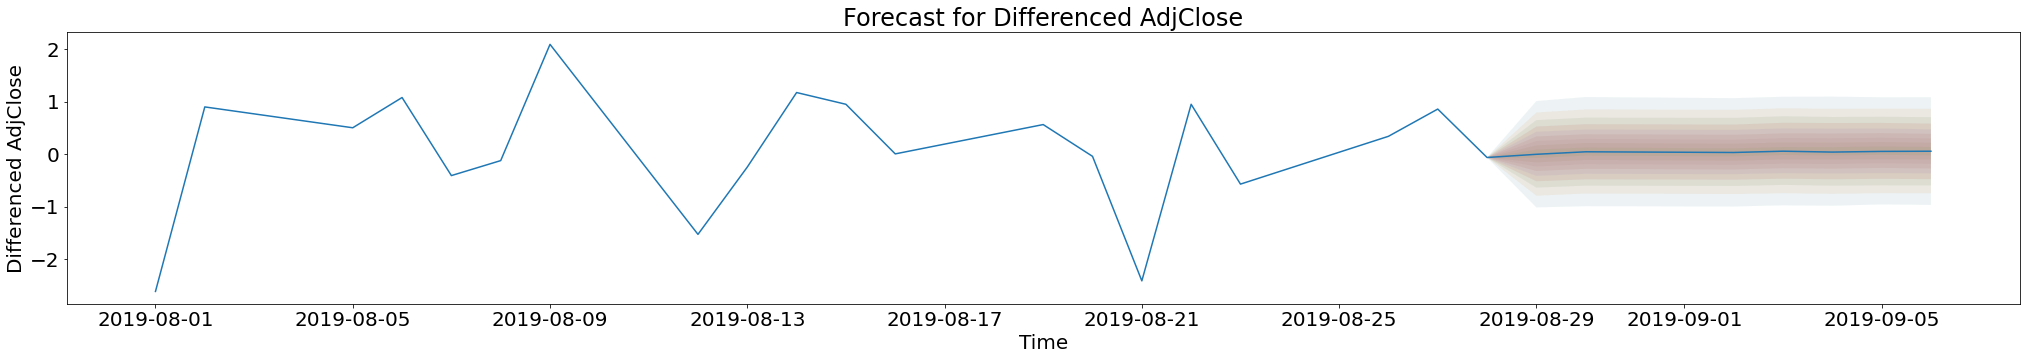

In [57]:
model3.plot_predict(h=7, oos_data=test, figsize=(35,5))

In [58]:
model3_est=model3.predict(h=7, oos_data=appl,)
model3_est 

,Differenced AdjClose
Date,
2019-08-29,-0.025315
2019-08-30,0.051128
2019-09-02,0.021967
2019-09-03,0.011028
2019-09-04,-0.002676
2019-09-05,-0.025033
2019-09-06,0.041494


In [59]:
model3_est.values

array([[-0.02531477],
       [ 0.05112837],
       [ 0.02196699],
       [ 0.01102783],
       [-0.00267566],
       [-0.02503312],
       [ 0.04149379]])

In [60]:
model3_est = np.delete(model3_est.values, [2])

In [61]:
model3_est

array([-0.02531477,  0.05112837,  0.01102783, -0.00267566, -0.02503312,
        0.04149379])

In [62]:
print('Mean Squared Error:', (mean_squared_error(dif, model3_est)))

Mean Squared Error: 0.39832343017404387


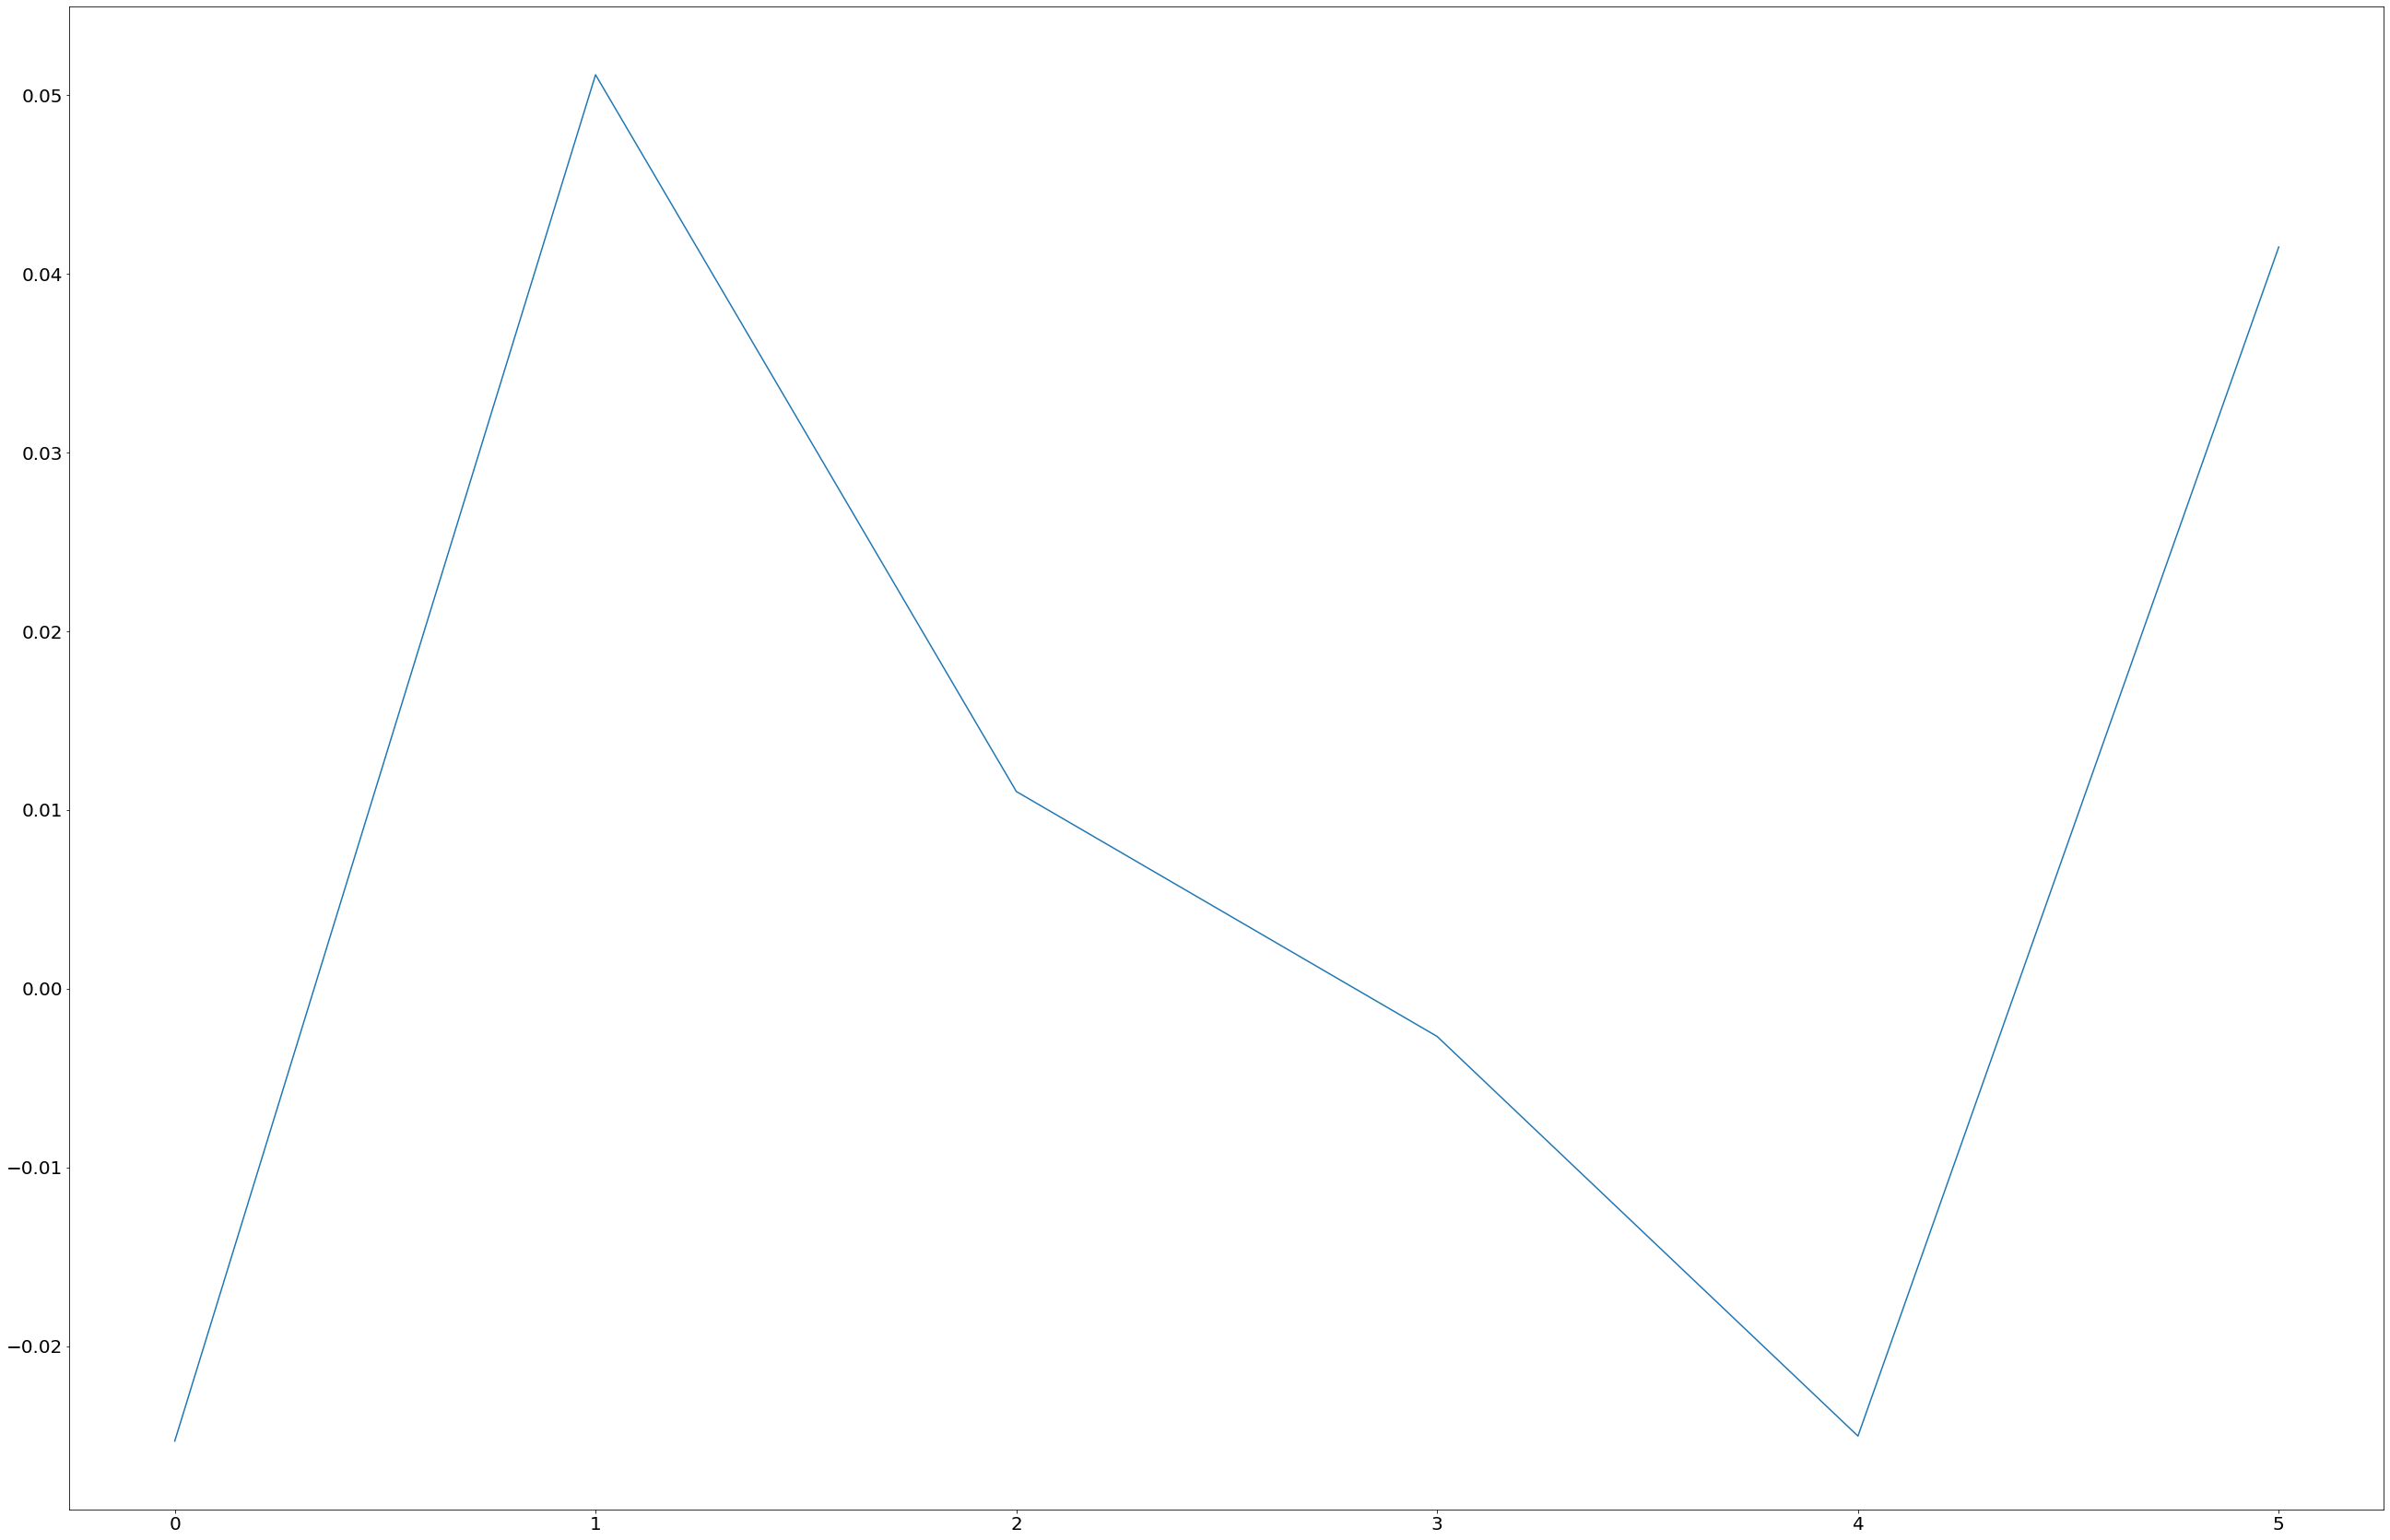

In [63]:
plt.plot(model3_est, label = 'forecast')